In [2]:
def f_exact(x, t):
    return torch.cos(t) - np.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return np.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (np.pi/2*torch.cos(x) + (x - np.pi/2)) * torch.cos(t)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [4]:
def gen_data(L, t_end, n_t, n_x=5):
    "generates data in a way that mimics sensors. n_x is number of sensors, n_t is number of time points per sensor"
    x_coords = torch.linspace(0, L, n_x)
    t_times = torch.linspace(0, t_end, n_t)

    x_vals = x_coords.repeat_interleave(n_t)
    t_vals = t_times.repeat(n_x)
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals), theta_exact(x_vals, t_vals))

In [5]:
def split_train_val(val_frac, *tensors):
    N = tensors[0].shape[0]
    perm = torch.randperm(N)
    n_val = int(N * val_frac)
    val_idx, train_idx = perm[:n_val], perm[n_val:]
    return (tuple(t[train_idx] for t in tensors),
            tuple(t[val_idx]   for t in tensors))

70 30 100


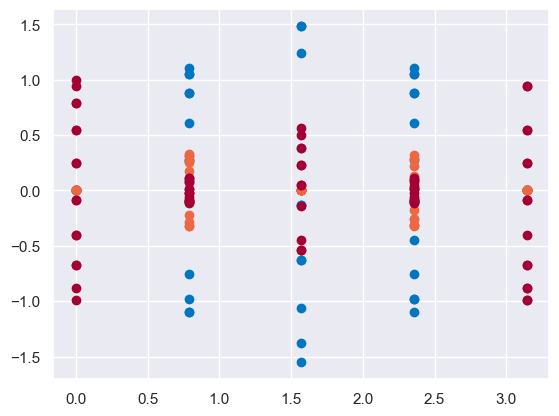

In [6]:
x, t, f, u, theta = gen_data(torch.pi, 2 * torch.pi, 20, 5)

(train_x, train_t, train_f, train_u, train_theta), \
(val_x,   val_t,   val_f,   val_u,   val_theta) = split_train_val(
    0.3, x, t, f, u, theta
)

plt.plot(train_x.numpy(), train_u.numpy(), 'o')
plt.plot(train_x.numpy(), train_theta.numpy(), 'o')
plt.plot(train_x.numpy(), train_f.numpy(), 'o')
print(train_theta.shape[0], val_theta.shape[0], theta.shape[0])

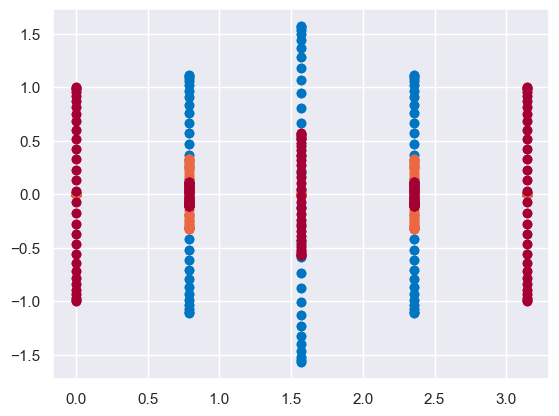

In [7]:
t_end = 2*np.pi
x, t, f, u, theta = gen_data(np.pi, t_end, int(t_end/0.1), 5)
plt.plot(x.numpy(), u.numpy(), 'o')
plt.plot(x.numpy(), theta.numpy(), 'o')
plt.plot(x.numpy(), f.numpy(), 'o')

In [8]:
# training data generation
t_end = 2*np.pi

generated_data = gen_data(np.pi, t_end, int(t_end/0.1), 5)
(x_gen, t_gen, f_gen, u_gen, theta_gen), (x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val) = split_train_val(0.1, *generated_data)


# x_gen, t_gen, f_gen, u_gen, theta_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32), torch.tensor(theta_gen, dtype=torch.float32)
# x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32), torch.tensor(theta_gen_val, dtype=torch.float32)

In [9]:
print(int( t_end/0.1*5))  # number of training points

314


In [10]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [12]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300

validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [13]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [14]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = t_end

# Set sample sizes
N_f = 1000 #2000   # collocation points in interior
N_ic = 200 #256   # initial condition samples at t=0
N_bc = 200 #256   # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 250

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.7324634191189479
lambda_ic = 0.33169472587793747
lambda_bc = 0.14122575733247608
lambda_physics = 0.1361579824702817

lambdas = (lambda_data, lambda_ic, lambda_bc, lambda_physics)
# echo on screen
echo_every = 75


In [15]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            # ---------------------- student exercise --------------------------------- #
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())
            # ---------------------- student exercise --------------------------------- #

    return np.array(losses).mean()

In [16]:
def training_loop(pinn, optimiser, trial, lambdas):    
    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()

    lambda_data, lambda_ic, lambda_bc, lambda_physics = lambdas

    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        full_pred_data_norm = pinn(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
        loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
        loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

        # compute boundary loss
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = ((dudt - 0)**2).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = ((dthetadt - 0)**2).mean()

        loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = ((u - 0)**2).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = ((theta - 0)**2).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = ((u - 0)**2).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = ((theta - 0)**2).mean()

        loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

        #compute physics loss
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm
        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm
        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(physics_residual_1**2)
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
        loss_physics_2 = torch.mean(physics_residual_2**2)

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())
        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            #print(f"Epoch {i}: total loss = {loss}, loss1 = {loss1}, loss2 = {loss2}, loss3 = {loss3}, loss4 = {loss4}, loss5 = {loss5}, loss6 = {loss6}, loss7 = {loss7}, loss_data_u = {loss_data_u}, loss_data_theta = {loss_data_theta}")
            print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")
        
            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()
        # Check if the trial has exceeded the maximum allowed time
        
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()

    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

In [17]:
def objective_architecture(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    pinn = MLP(2,hidden_size,2, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.Adam(pinn.parameters(),lr=learning_rate)
    validation_loss = training_loop(pinn, optimiser, trial, lambdas=lambdas)

    return validation_loss

In [18]:
def objective_lambdas(trial_w):
    lambda_data = trial_w.suggest_float('lambda_data', 0.1, 1, log=True)
    lambda_ic = trial_w.suggest_float('lambda_ic', 0.1, 1)
    lambda_bc = trial_w.suggest_float('lambda_bc', 0.1, 1, log=True)
    lambda_physics = trial_w.suggest_float('lambda_physics', 0.1, 1)

    lambdas_suggested = (lambda_data, lambda_ic, lambda_bc, lambda_physics)

    # setup the PINN with the best architecture found
    # using global variable defined after the cell is not great practice, but cannot easily be avoided due to Optuna structure

    pinn = MLP(2,trial_archi.params['hidden_size'],2, num_hid_layers=trial_archi.params['num_layers']).to(device)   
    optimiser = torch.optim.Adam(pinn.parameters(),lr=trial_archi.params['learning_rate'])

    validation_loss = training_loop(pinn, optimiser, trial_w, lambdas=lambdas_suggested)
    
    return validation_loss

In [19]:
# This cell will first optimize the architecture, then optimize the lambdas using the best architecture found.
# Note that this will take a while (~30 minutes with reduced data) to run!
# If you have a model file, you might want to skip this and following cells and continue at the marked cell.

study_architecture = optuna.create_study(direction='minimize')
study_architecture.optimize(objective_architecture, n_trials=50)

pruned_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

trial_archi = study_architecture.best_trial

n_epochs = 250

study_lambdas = optuna.create_study(direction='minimize')
study_lambdas.optimize(objective_lambdas, n_trials=50)
pruned_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# summaries of both studies
print("Study architecture statistics: ")
print("  Number of finished trials: ", len(study_architecture.trials))
print("  Number of pruned trials: ", len(pruned_trials_archi))
print("  Number of complete trials: ", len(complete_trials_archi))

print("Best trial architecture:")


print("  Value: ", trial_archi.value)

print("  Params: ")
for key, value in trial_archi.params.items():
    print("    {}: {}".format(key, value))


print("Study lambdas statistics: ")
print("  Number of finished trials: ", len(study_lambdas.trials))
print("  Number of pruned trials: ", len(pruned_trials_lambdas))
print("  Number of complete trials: ", len(complete_trials_lambdas))
print("Best trial lambdas:")

trial_lambdas = study_lambdas.best_trial
print("  Value: ", trial_lambdas.value)

print("  Params: ")
for key, value in trial_lambdas.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-27 21:39:42,520] A new study created in memory with name: no-name-f9a527e6-20af-4462-9dda-7612efa78c18


Epoch 0: total loss = 1.936230, Initial_u = 1.086479, Initial_u_t = 0.000842, Initial_theta = 0.050889, Initial_theta_t = 0.000001, BC_left_u = 0.016329, BC_left_theta = 0.000104, BC_right_u = 0.014882, BC_right_theta = 0.001768, Physics_1 = 0.000579, Physics_2 = 0.121311
Validation loss at epoch 0: 1.029660
Epoch 75: total loss = 0.677094, Initial_u = 0.075255, Initial_u_t = 0.127841, Initial_theta = 0.022203, Initial_theta_t = 0.003024, BC_left_u = 0.070023, BC_left_theta = 0.004346, BC_right_u = 0.086909, BC_right_theta = 0.004464, Physics_1 = 0.043871, Physics_2 = 0.207811
Validation loss at epoch 75: 0.391084
Epoch 150: total loss = 0.188605, Initial_u = 0.018169, Initial_u_t = 0.039764, Initial_theta = 0.002135, Initial_theta_t = 0.015919, BC_left_u = 0.013697, BC_left_theta = 0.001690, BC_right_u = 0.021487, BC_right_theta = 0.002147, Physics_1 = 0.320199, Physics_2 = 0.242109
Validation loss at epoch 150: 0.069167
Epoch 225: total loss = 0.106528, Initial_u = 0.006960, Initial_

[I 2026-01-27 21:39:52,558] Trial 0 finished with value: 0.03270227462053299 and parameters: {'hidden_size': 150, 'learning_rate': 0.000780648474591393, 'num_layers': 1}. Best is trial 0 with value: 0.03270227462053299.


  Params: 
    hidden_size: 150
    learning_rate: 0.000780648474591393
    num_layers: 1
Epoch 0: total loss = 1.996864, Initial_u = 1.418377, Initial_u_t = 0.000977, Initial_theta = 0.050254, Initial_theta_t = 0.000009, BC_left_u = 0.006139, BC_left_theta = 0.000090, BC_right_u = 0.006400, BC_right_theta = 0.000054, Physics_1 = 0.000820, Physics_2 = 0.115080
Validation loss at epoch 0: 1.069734
Epoch 75: total loss = 0.354137, Initial_u = 0.035784, Initial_u_t = 0.080349, Initial_theta = 0.003281, Initial_theta_t = 0.018001, BC_left_u = 0.041965, BC_left_theta = 0.006154, BC_right_u = 0.062913, BC_right_theta = 0.008127, Physics_1 = 0.125495, Physics_2 = 0.311692
Validation loss at epoch 75: 0.175543
Epoch 150: total loss = 0.124705, Initial_u = 0.011932, Initial_u_t = 0.019862, Initial_theta = 0.001127, Initial_theta_t = 0.012306, BC_left_u = 0.016857, BC_left_theta = 0.000921, BC_right_u = 0.021965, BC_right_theta = 0.001053, Physics_1 = 0.286234, Physics_2 = 0.202431
Validation lo

[I 2026-01-27 21:40:02,653] Trial 1 finished with value: 0.017362458631396294 and parameters: {'hidden_size': 450, 'learning_rate': 0.0002134931664000006, 'num_layers': 2}. Best is trial 1 with value: 0.017362458631396294.


  Params: 
    hidden_size: 450
    learning_rate: 0.0002134931664000006
    num_layers: 2
Epoch 0: total loss = 1.944645, Initial_u = 1.355750, Initial_u_t = 0.000155, Initial_theta = 0.059962, Initial_theta_t = 0.000005, BC_left_u = 0.001481, BC_left_theta = 0.000110, BC_right_u = 0.003209, BC_right_theta = 0.000040, Physics_1 = 0.000193, Physics_2 = 0.105473
Validation loss at epoch 0: 1.030724
Epoch 75: total loss = 0.681091, Initial_u = 0.069621, Initial_u_t = 0.052541, Initial_theta = 0.011630, Initial_theta_t = 0.007626, BC_left_u = 0.079030, BC_left_theta = 0.010843, BC_right_u = 0.110543, BC_right_theta = 0.012026, Physics_1 = 0.061896, Physics_2 = 0.262266
Validation loss at epoch 75: 0.393755
Epoch 150: total loss = 0.202415, Initial_u = 0.016862, Initial_u_t = 0.022074, Initial_theta = 0.000956, Initial_theta_t = 0.017311, BC_left_u = 0.031893, BC_left_theta = 0.003399, BC_right_u = 0.028696, BC_right_theta = 0.002834, Physics_1 = 0.356644, Physics_2 = 0.318091
Validation l

[I 2026-01-27 21:40:14,397] Trial 2 finished with value: 0.032881107181310654 and parameters: {'hidden_size': 250, 'learning_rate': 0.00017112462120963165, 'num_layers': 3}. Best is trial 1 with value: 0.017362458631396294.


  Params: 
    hidden_size: 250
    learning_rate: 0.00017112462120963165
    num_layers: 3
Epoch 0: total loss = 1.931963, Initial_u = 1.229965, Initial_u_t = 0.000320, Initial_theta = 0.057438, Initial_theta_t = 0.000010, BC_left_u = 0.004901, BC_left_theta = 0.000173, BC_right_u = 0.000140, BC_right_theta = 0.000489, Physics_1 = 0.000051, Physics_2 = 0.122997
Validation loss at epoch 0: 0.994415
Epoch 75: total loss = 1.372964, Initial_u = 0.270432, Initial_u_t = 0.061609, Initial_theta = 0.059520, Initial_theta_t = 0.000216, BC_left_u = 0.018001, BC_left_theta = 0.000006, BC_right_u = 0.028468, BC_right_theta = 0.000413, Physics_1 = 0.017944, Physics_2 = 0.140364
Validation loss at epoch 75: 0.857318
Epoch 150: total loss = 0.722976, Initial_u = 0.072247, Initial_u_t = 0.086923, Initial_theta = 0.024595, Initial_theta_t = 0.002202, BC_left_u = 0.088375, BC_left_theta = 0.006029, BC_right_u = 0.088420, BC_right_theta = 0.004712, Physics_1 = 0.085938, Physics_2 = 0.283709
Validation 

[I 2026-01-27 21:40:26,983] Trial 3 finished with value: 0.09617017954587936 and parameters: {'hidden_size': 100, 'learning_rate': 0.00019678158969719143, 'num_layers': 3}. Best is trial 1 with value: 0.017362458631396294.


  Params: 
    hidden_size: 100
    learning_rate: 0.00019678158969719143
    num_layers: 3
Epoch 0: total loss = 2.074726, Initial_u = 1.549325, Initial_u_t = 0.000405, Initial_theta = 0.051534, Initial_theta_t = 0.000006, BC_left_u = 0.045960, BC_left_theta = 0.001944, BC_right_u = 0.009657, BC_right_theta = 0.000612, Physics_1 = 0.003521, Physics_2 = 0.118508
Validation loss at epoch 0: 1.308289
Epoch 75: total loss = 0.252505, Initial_u = 0.025685, Initial_u_t = 0.049454, Initial_theta = 0.003889, Initial_theta_t = 0.019761, BC_left_u = 0.031081, BC_left_theta = 0.002744, BC_right_u = 0.034623, BC_right_theta = 0.003585, Physics_1 = 0.371997, Physics_2 = 0.268140
Validation loss at epoch 75: 0.093920
Epoch 150: total loss = 0.098241, Initial_u = 0.006987, Initial_u_t = 0.008789, Initial_theta = 0.000934, Initial_theta_t = 0.011674, BC_left_u = 0.012171, BC_left_theta = 0.000654, BC_right_u = 0.015109, BC_right_theta = 0.000953, Physics_1 = 0.236776, Physics_2 = 0.132226
Validation 

[I 2026-01-27 21:40:35,085] Trial 4 finished with value: 0.015649233013391495 and parameters: {'hidden_size': 300, 'learning_rate': 0.0012091505087741948, 'num_layers': 1}. Best is trial 4 with value: 0.015649233013391495.


  Params: 
    hidden_size: 300
    learning_rate: 0.0012091505087741948
    num_layers: 1
Epoch 0: total loss = 1.885995, Initial_u = 1.166279, Initial_u_t = 0.000024, Initial_theta = 0.054706, Initial_theta_t = 0.000001, BC_left_u = 0.000122, BC_left_theta = 0.000050, BC_right_u = 0.000105, BC_right_theta = 0.000001, Physics_1 = 0.000086, Physics_2 = 0.117915
Validation loss at epoch 0: 1.107628
Epoch 75: total loss = 0.191275, Initial_u = 0.011969, Initial_u_t = 0.031337, Initial_theta = 0.001190, Initial_theta_t = 0.016896, BC_left_u = 0.023664, BC_left_theta = 0.001938, BC_right_u = 0.019963, BC_right_theta = 0.001848, Physics_1 = 0.414652, Physics_2 = 0.276981
Validation loss at epoch 75: 0.062881
Epoch 150: total loss = 0.100444, Initial_u = 0.003040, Initial_u_t = 0.007543, Initial_theta = 0.001404, Initial_theta_t = 0.005400, BC_left_u = 0.012235, BC_left_theta = 0.001532, BC_right_u = 0.009360, BC_right_theta = 0.001198, Physics_1 = 0.194463, Physics_2 = 0.133646
Validation l

[I 2026-01-27 21:40:46,786] Trial 5 finished with value: 0.024109570309519768 and parameters: {'hidden_size': 300, 'learning_rate': 0.000613936444941183, 'num_layers': 3}. Best is trial 4 with value: 0.015649233013391495.


  Params: 
    hidden_size: 300
    learning_rate: 0.000613936444941183
    num_layers: 3
Epoch 0: total loss = 1.825678, Initial_u = 0.870753, Initial_u_t = 0.000197, Initial_theta = 0.058297, Initial_theta_t = 0.000009, BC_left_u = 0.032648, BC_left_theta = 0.000017, BC_right_u = 0.002451, BC_right_theta = 0.000074, Physics_1 = 0.004754, Physics_2 = 0.123082
Validation loss at epoch 0: 1.084646
Epoch 75: total loss = 0.446884, Initial_u = 0.050395, Initial_u_t = 0.136815, Initial_theta = 0.006368, Initial_theta_t = 0.013035, BC_left_u = 0.027971, BC_left_theta = 0.006230, BC_right_u = 0.066593, BC_right_theta = 0.005538, Physics_1 = 0.076041, Physics_2 = 0.294230
Validation loss at epoch 75: 0.217317
Epoch 150: total loss = 0.147508, Initial_u = 0.014796, Initial_u_t = 0.025882, Initial_theta = 0.001106, Initial_theta_t = 0.011510, BC_left_u = 0.017091, BC_left_theta = 0.001307, BC_right_u = 0.023739, BC_right_theta = 0.001690, Physics_1 = 0.299985, Physics_2 = 0.196223
Validation lo

[I 2026-01-27 21:40:54,670] Trial 6 finished with value: 0.02051292546093464 and parameters: {'hidden_size': 100, 'learning_rate': 0.0012229958219644196, 'num_layers': 1}. Best is trial 4 with value: 0.015649233013391495.


  Params: 
    hidden_size: 100
    learning_rate: 0.0012229958219644196
    num_layers: 1
Epoch 0: total loss = 1.905342, Initial_u = 1.183010, Initial_u_t = 0.000016, Initial_theta = 0.059233, Initial_theta_t = 0.000008, BC_left_u = 0.003996, BC_left_theta = 0.000310, BC_right_u = 0.000567, BC_right_theta = 0.000325, Physics_1 = 0.001232, Physics_2 = 0.116658
Validation loss at epoch 0: 1.045709


[I 2026-01-27 21:40:57,634] Trial 7 pruned. 


Epoch 75: total loss = 0.864480, Initial_u = 0.072759, Initial_u_t = 0.184659, Initial_theta = 0.028276, Initial_theta_t = 0.002600, BC_left_u = 0.094077, BC_left_theta = 0.004959, BC_right_u = 0.088469, BC_right_theta = 0.004166, Physics_1 = 0.029423, Physics_2 = 0.230599
Validation loss at epoch 75: 0.488285
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.00011753084830843297
    num_layers: 2
Epoch 0: total loss = 1.898326, Initial_u = 1.188718, Initial_u_t = 0.000002, Initial_theta = 0.055657, Initial_theta_t = 0.000001, BC_left_u = 0.000819, BC_left_theta = 0.000063, BC_right_u = 0.001311, BC_right_theta = 0.000032, Physics_1 = 0.000501, Physics_2 = 0.115823
Validation loss at epoch 0: 1.093262
Epoch 75: total loss = 0.171659, Initial_u = 0.023488, Initial_u_t = 0.024298, Initial_theta = 0.001622, Initial_theta_t = 0.011687, BC_left_u = 0.021190, BC_left_theta = 0.001684, BC_right_u = 0.019406, BC_right_theta = 0.001438, Physics_1 = 0.348349, Physics_2 = 0.259279
Vali

[I 2026-01-27 21:41:09,781] Trial 8 finished with value: 0.07520049065351486 and parameters: {'hidden_size': 200, 'learning_rate': 0.0009159372435217204, 'num_layers': 3}. Best is trial 4 with value: 0.015649233013391495.


  Params: 
    hidden_size: 200
    learning_rate: 0.0009159372435217204
    num_layers: 3
Epoch 0: total loss = 1.911382, Initial_u = 1.232741, Initial_u_t = 0.000062, Initial_theta = 0.057012, Initial_theta_t = 0.000017, BC_left_u = 0.000073, BC_left_theta = 0.000269, BC_right_u = 0.007265, BC_right_theta = 0.000410, Physics_1 = 0.000365, Physics_2 = 0.114668
Validation loss at epoch 0: 1.053161


[I 2026-01-27 21:41:12,139] Trial 9 pruned. 


Epoch 75: total loss = 0.556617, Initial_u = 0.086597, Initial_u_t = 0.121563, Initial_theta = 0.010110, Initial_theta_t = 0.008811, BC_left_u = 0.074263, BC_left_theta = 0.005678, BC_right_u = 0.066323, BC_right_theta = 0.006488, Physics_1 = 0.040536, Physics_2 = 0.223936
Validation loss at epoch 75: 0.301275
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0005354165800980287
    num_layers: 1
Epoch 0: total loss = 1.870499, Initial_u = 1.010746, Initial_u_t = 0.000305, Initial_theta = 0.063912, Initial_theta_t = 0.000031, BC_left_u = 0.001957, BC_left_theta = 0.000450, BC_right_u = 0.011405, BC_right_theta = 0.000476, Physics_1 = 0.001734, Physics_2 = 0.112432
Validation loss at epoch 0: 36.320961
Epoch 75: total loss = 0.068027, Initial_u = 0.005714, Initial_u_t = 0.005045, Initial_theta = 0.000513, Initial_theta_t = 0.011107, BC_left_u = 0.003662, BC_left_theta = 0.000315, BC_right_u = 0.007030, BC_right_theta = 0.000508, Physics_1 = 0.199542, Physics_2 = 0.118515
Vali

[I 2026-01-27 21:41:20,227] Trial 10 finished with value: 0.004982813727110624 and parameters: {'hidden_size': 500, 'learning_rate': 0.008931141774630646, 'num_layers': 1}. Best is trial 10 with value: 0.004982813727110624.


  Params: 
    hidden_size: 500
    learning_rate: 0.008931141774630646
    num_layers: 1
Epoch 0: total loss = 1.894878, Initial_u = 1.004416, Initial_u_t = 0.000590, Initial_theta = 0.052633, Initial_theta_t = 0.000072, BC_left_u = 0.017646, BC_left_theta = 0.000530, BC_right_u = 0.049250, BC_right_theta = 0.000259, Physics_1 = 0.009156, Physics_2 = 0.112695
Validation loss at epoch 0: 34.370686
Epoch 75: total loss = 0.056943, Initial_u = 0.004771, Initial_u_t = 0.005834, Initial_theta = 0.000391, Initial_theta_t = 0.008905, BC_left_u = 0.005353, BC_left_theta = 0.000301, BC_right_u = 0.009035, BC_right_theta = 0.000623, Physics_1 = 0.141564, Physics_2 = 0.079779
Validation loss at epoch 75: 0.023893
Epoch 150: total loss = 0.024683, Initial_u = 0.000403, Initial_u_t = 0.000610, Initial_theta = 0.000170, Initial_theta_t = 0.001858, BC_left_u = 0.002505, BC_left_theta = 0.000075, BC_right_u = 0.006204, BC_right_theta = 0.000302, Physics_1 = 0.069868, Physics_2 = 0.032198
Validation l

[I 2026-01-27 21:41:28,182] Trial 11 finished with value: 0.013178029097616673 and parameters: {'hidden_size': 500, 'learning_rate': 0.008537142845710425, 'num_layers': 1}. Best is trial 10 with value: 0.004982813727110624.


  Params: 
    hidden_size: 500
    learning_rate: 0.008537142845710425
    num_layers: 1
Epoch 0: total loss = 1.942062, Initial_u = 1.307469, Initial_u_t = 0.000335, Initial_theta = 0.055355, Initial_theta_t = 0.000004, BC_left_u = 0.007047, BC_left_theta = 0.000185, BC_right_u = 0.002703, BC_right_theta = 0.000014, Physics_1 = 0.000229, Physics_2 = 0.117582
Validation loss at epoch 0: 4.938633


[I 2026-01-27 21:41:31,211] Trial 12 pruned. 


Epoch 75: total loss = 0.485640, Initial_u = 0.011889, Initial_u_t = 0.011477, Initial_theta = 0.003600, Initial_theta_t = 0.003274, BC_left_u = 0.024780, BC_left_theta = 0.001155, BC_right_u = 0.007710, BC_right_theta = 0.000886, Physics_1 = 0.239196, Physics_2 = 0.585898
Validation loss at epoch 75: 0.292614
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.011903149577144275
    num_layers: 2
Epoch 0: total loss = 2.084876, Initial_u = 1.557193, Initial_u_t = 0.000554, Initial_theta = 0.054873, Initial_theta_t = 0.000073, BC_left_u = 0.037509, BC_left_theta = 0.001520, BC_right_u = 0.008629, BC_right_theta = 0.000544, Physics_1 = 0.002686, Physics_2 = 0.122989
Validation loss at epoch 0: 24.207952
Epoch 75: total loss = 0.074905, Initial_u = 0.008295, Initial_u_t = 0.009556, Initial_theta = 0.000589, Initial_theta_t = 0.010618, BC_left_u = 0.005639, BC_left_theta = 0.000497, BC_right_u = 0.007754, BC_right_theta = 0.000557, Physics_1 = 0.199399, Physics_2 = 0.098135
Valid

[I 2026-01-27 21:41:39,251] Trial 13 finished with value: 0.007814465090632439 and parameters: {'hidden_size': 400, 'learning_rate': 0.009010458497130376, 'num_layers': 1}. Best is trial 10 with value: 0.004982813727110624.


  Params: 
    hidden_size: 400
    learning_rate: 0.009010458497130376
    num_layers: 1
Epoch 0: total loss = 1.849480, Initial_u = 1.028230, Initial_u_t = 0.000785, Initial_theta = 0.056025, Initial_theta_t = 0.000001, BC_left_u = 0.002089, BC_left_theta = 0.000052, BC_right_u = 0.005342, BC_right_theta = 0.000172, Physics_1 = 0.000188, Physics_2 = 0.113702
Validation loss at epoch 0: 45.636719


[I 2026-01-27 21:41:41,787] Trial 14 pruned. 


Epoch 75: total loss = 0.964179, Initial_u = 0.190655, Initial_u_t = 0.063912, Initial_theta = 0.033619, Initial_theta_t = 0.002914, BC_left_u = 0.088879, BC_left_theta = 0.002513, BC_right_u = 0.058250, BC_right_theta = 0.003940, Physics_1 = 0.155882, Physics_2 = 0.306072
Validation loss at epoch 75: 0.626371
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.044282617250296655
    num_layers: 1
Epoch 0: total loss = 1.906323, Initial_u = 1.216204, Initial_u_t = 0.000170, Initial_theta = 0.054892, Initial_theta_t = 0.000007, BC_left_u = 0.004684, BC_left_theta = 0.000581, BC_right_u = 0.005336, BC_right_theta = 0.000055, Physics_1 = 0.003306, Physics_2 = 0.131297
Validation loss at epoch 0: 9.027256
Epoch 75: total loss = 0.066526, Initial_u = 0.008781, Initial_u_t = 0.018293, Initial_theta = 0.000976, Initial_theta_t = 0.008629, BC_left_u = 0.010135, BC_left_theta = 0.000582, BC_right_u = 0.003673, BC_right_theta = 0.000428, Physics_1 = 0.160857, Physics_2 = 0.077916
Valida

[I 2026-01-27 21:41:52,163] Trial 15 finished with value: 0.0014765722444280982 and parameters: {'hidden_size': 400, 'learning_rate': 0.005626572141070824, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 400
    learning_rate: 0.005626572141070824
    num_layers: 2
Epoch 0: total loss = 1.883747, Initial_u = 1.053509, Initial_u_t = 0.000154, Initial_theta = 0.053840, Initial_theta_t = 0.000027, BC_left_u = 0.022436, BC_left_theta = 0.000292, BC_right_u = 0.000008, BC_right_theta = 0.000218, Physics_1 = 0.003208, Physics_2 = 0.117350
Validation loss at epoch 0: 8.531313
Epoch 75: total loss = 0.080570, Initial_u = 0.008460, Initial_u_t = 0.010799, Initial_theta = 0.000573, Initial_theta_t = 0.006555, BC_left_u = 0.013093, BC_left_theta = 0.000638, BC_right_u = 0.014077, BC_right_theta = 0.001203, Physics_1 = 0.205432, Physics_2 = 0.113762
Validation loss at epoch 75: 0.026066
Epoch 150: total loss = 0.058599, Initial_u = 0.004334, Initial_u_t = 0.001881, Initial_theta = 0.000561, Initial_theta_t = 0.003204, BC_left_u = 0.003504, BC_left_theta = 0.000265, BC_right_u = 0.006027, BC_right_theta = 0.000623, Physics_1 = 0.182714, Physics_2 = 0.064185
Validation lo

[I 2026-01-27 21:42:02,312] Trial 16 finished with value: 0.009627517312765121 and parameters: {'hidden_size': 400, 'learning_rate': 0.004336218142424232, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 400
    learning_rate: 0.004336218142424232
    num_layers: 2
Epoch 0: total loss = 1.925277, Initial_u = 1.312699, Initial_u_t = 0.000035, Initial_theta = 0.057108, Initial_theta_t = 0.000007, BC_left_u = 0.001257, BC_left_theta = 0.000024, BC_right_u = 0.003796, BC_right_theta = 0.000478, Physics_1 = 0.000827, Physics_2 = 0.119691
Validation loss at epoch 0: 21.715769


[I 2026-01-27 21:42:05,290] Trial 17 pruned. 


Epoch 75: total loss = 1.854113, Initial_u = 0.901654, Initial_u_t = 0.000018, Initial_theta = 0.052818, Initial_theta_t = 0.000002, BC_left_u = 0.033854, BC_left_theta = 0.000001, BC_right_u = 0.030214, BC_right_theta = 0.000022, Physics_1 = 0.005134, Physics_2 = 0.128321
Validation loss at epoch 75: 1.025637
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.026075581487398417
    num_layers: 2
Epoch 0: total loss = 1.888009, Initial_u = 1.138577, Initial_u_t = 0.000087, Initial_theta = 0.057497, Initial_theta_t = 0.000012, BC_left_u = 0.003248, BC_left_theta = 0.000100, BC_right_u = 0.006034, BC_right_theta = 0.000114, Physics_1 = 0.001641, Physics_2 = 0.125148
Validation loss at epoch 0: 11.202577
Epoch 75: total loss = 0.086868, Initial_u = 0.015077, Initial_u_t = 0.025478, Initial_theta = 0.000992, Initial_theta_t = 0.006233, BC_left_u = 0.014073, BC_left_theta = 0.000609, BC_right_u = 0.007271, BC_right_theta = 0.000539, Physics_1 = 0.189665, Physics_2 = 0.110235
Valid

[I 2026-01-27 21:42:15,089] Trial 18 finished with value: 0.0021672407165169716 and parameters: {'hidden_size': 500, 'learning_rate': 0.0037622355066667624, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 500
    learning_rate: 0.0037622355066667624
    num_layers: 2
Epoch 0: total loss = 1.850444, Initial_u = 0.918712, Initial_u_t = 0.000530, Initial_theta = 0.054333, Initial_theta_t = 0.000061, BC_left_u = 0.012213, BC_left_theta = 0.000123, BC_right_u = 0.003612, BC_right_theta = 0.001584, Physics_1 = 0.000677, Physics_2 = 0.117795
Validation loss at epoch 0: 4.354585
Epoch 75: total loss = 0.101042, Initial_u = 0.008531, Initial_u_t = 0.006626, Initial_theta = 0.001157, Initial_theta_t = 0.007138, BC_left_u = 0.013328, BC_left_theta = 0.000982, BC_right_u = 0.009162, BC_right_theta = 0.000689, Physics_1 = 0.258009, Physics_2 = 0.138193
Validation loss at epoch 75: 0.037990
Epoch 150: total loss = 0.042684, Initial_u = 0.000640, Initial_u_t = 0.000618, Initial_theta = 0.000243, Initial_theta_t = 0.002095, BC_left_u = 0.003416, BC_left_theta = 0.000442, BC_right_u = 0.008689, BC_right_theta = 0.001282, Physics_1 = 0.085990, Physics_2 = 0.042479
Validation l

[I 2026-01-27 21:42:24,759] Trial 19 finished with value: 0.14388586580753326 and parameters: {'hidden_size': 350, 'learning_rate': 0.0026454946487925375, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 350
    learning_rate: 0.0026454946487925375
    num_layers: 2
Epoch 0: total loss = 1.909007, Initial_u = 1.235381, Initial_u_t = 0.000205, Initial_theta = 0.052280, Initial_theta_t = 0.000014, BC_left_u = 0.002374, BC_left_theta = 0.000013, BC_right_u = 0.002807, BC_right_theta = 0.000191, Physics_1 = 0.000275, Physics_2 = 0.113522
Validation loss at epoch 0: 6.424407
Epoch 75: total loss = 0.081726, Initial_u = 0.006211, Initial_u_t = 0.010533, Initial_theta = 0.000516, Initial_theta_t = 0.007377, BC_left_u = 0.011912, BC_left_theta = 0.000587, BC_right_u = 0.013834, BC_right_theta = 0.001250, Physics_1 = 0.190204, Physics_2 = 0.122932
Validation loss at epoch 75: 0.025643
Epoch 150: total loss = 0.023354, Initial_u = 0.000218, Initial_u_t = 0.000217, Initial_theta = 0.000318, Initial_theta_t = 0.001052, BC_left_u = 0.004791, BC_left_theta = 0.000282, BC_right_u = 0.004152, BC_right_theta = 0.000249, Physics_1 = 0.059599, Physics_2 = 0.026806
Validation l

[I 2026-01-27 21:42:34,691] Trial 20 finished with value: 0.003482154570519924 and parameters: {'hidden_size': 450, 'learning_rate': 0.003575902013209751, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 450
    learning_rate: 0.003575902013209751
    num_layers: 2
Epoch 0: total loss = 1.860505, Initial_u = 1.052471, Initial_u_t = 0.000030, Initial_theta = 0.063269, Initial_theta_t = 0.000004, BC_left_u = 0.000606, BC_left_theta = 0.000958, BC_right_u = 0.005642, BC_right_theta = 0.000142, Physics_1 = 0.002773, Physics_2 = 0.109222
Validation loss at epoch 0: 8.384098
Epoch 75: total loss = 0.085769, Initial_u = 0.006361, Initial_u_t = 0.015433, Initial_theta = 0.000682, Initial_theta_t = 0.007826, BC_left_u = 0.005598, BC_left_theta = 0.000758, BC_right_u = 0.013647, BC_right_theta = 0.001162, Physics_1 = 0.222371, Physics_2 = 0.118657
Validation loss at epoch 75: 0.031461
Epoch 150: total loss = 0.023169, Initial_u = 0.000331, Initial_u_t = 0.000352, Initial_theta = 0.000339, Initial_theta_t = 0.001655, BC_left_u = 0.001670, BC_left_theta = 0.000094, BC_right_u = 0.004021, BC_right_theta = 0.000492, Physics_1 = 0.052621, Physics_2 = 0.026305
Validation lo

[I 2026-01-27 21:42:44,643] Trial 21 finished with value: 0.0041103484109044075 and parameters: {'hidden_size': 450, 'learning_rate': 0.0038094326354928486, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 450
    learning_rate: 0.0038094326354928486
    num_layers: 2
Epoch 0: total loss = 1.873404, Initial_u = 1.131780, Initial_u_t = 0.000053, Initial_theta = 0.056178, Initial_theta_t = 0.000010, BC_left_u = 0.001740, BC_left_theta = 0.000338, BC_right_u = 0.001026, BC_right_theta = 0.000037, Physics_1 = 0.000536, Physics_2 = 0.116341
Validation loss at epoch 0: 12.374274
Epoch 75: total loss = 0.080663, Initial_u = 0.007090, Initial_u_t = 0.007511, Initial_theta = 0.000987, Initial_theta_t = 0.006214, BC_left_u = 0.011482, BC_left_theta = 0.001005, BC_right_u = 0.004446, BC_right_theta = 0.000858, Physics_1 = 0.213340, Physics_2 = 0.098238
Validation loss at epoch 75: 0.023552
Epoch 150: total loss = 0.023229, Initial_u = 0.000117, Initial_u_t = 0.000529, Initial_theta = 0.000343, Initial_theta_t = 0.002432, BC_left_u = 0.005995, BC_left_theta = 0.000393, BC_right_u = 0.001050, BC_right_theta = 0.000139, Physics_1 = 0.066315, Physics_2 = 0.024081
Validation 

[I 2026-01-27 21:42:54,492] Trial 22 finished with value: 0.0026918272487819195 and parameters: {'hidden_size': 450, 'learning_rate': 0.004937711172764885, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 450
    learning_rate: 0.004937711172764885
    num_layers: 2
Epoch 0: total loss = 1.934605, Initial_u = 1.311275, Initial_u_t = 0.000074, Initial_theta = 0.060213, Initial_theta_t = 0.000002, BC_left_u = 0.001434, BC_left_theta = 0.000364, BC_right_u = 0.001895, BC_right_theta = 0.000357, Physics_1 = 0.001016, Physics_2 = 0.124590
Validation loss at epoch 0: 14.725789


[I 2026-01-27 21:42:57,438] Trial 23 pruned. 


Epoch 75: total loss = 0.289241, Initial_u = 0.020111, Initial_u_t = 0.015459, Initial_theta = 0.001646, Initial_theta_t = 0.000932, BC_left_u = 0.010092, BC_left_theta = 0.003357, BC_right_u = 0.012359, BC_right_theta = 0.001079, Physics_1 = 0.292715, Physics_2 = 0.481736
Validation loss at epoch 75: 0.140865
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.01662607296575418
    num_layers: 2
Epoch 0: total loss = 1.896974, Initial_u = 1.150689, Initial_u_t = 0.000162, Initial_theta = 0.059632, Initial_theta_t = 0.000003, BC_left_u = 0.003986, BC_left_theta = 0.000083, BC_right_u = 0.000981, BC_right_theta = 0.000061, Physics_1 = 0.000543, Physics_2 = 0.122687
Validation loss at epoch 0: 11.257262


[I 2026-01-27 21:43:00,524] Trial 24 pruned. 


Epoch 75: total loss = 0.116545, Initial_u = 0.023794, Initial_u_t = 0.094019, Initial_theta = 0.002937, Initial_theta_t = 0.007900, BC_left_u = 0.009556, BC_left_theta = 0.000505, BC_right_u = 0.011474, BC_right_theta = 0.000967, Physics_1 = 0.177003, Physics_2 = 0.114967
Validation loss at epoch 75: 0.040607
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.005448750570349928
    num_layers: 2
Epoch 0: total loss = 1.946894, Initial_u = 1.358796, Initial_u_t = 0.000074, Initial_theta = 0.048867, Initial_theta_t = 0.000008, BC_left_u = 0.001683, BC_left_theta = 0.000060, BC_right_u = 0.001222, BC_right_theta = 0.000046, Physics_1 = 0.000231, Physics_2 = 0.120015
Validation loss at epoch 0: 2.256795


[I 2026-01-27 21:43:04,165] Trial 25 pruned. 


Epoch 75: total loss = 0.257100, Initial_u = 0.003970, Initial_u_t = 0.002655, Initial_theta = 0.002246, Initial_theta_t = 0.005091, BC_left_u = 0.036008, BC_left_theta = 0.009568, BC_right_u = 0.010117, BC_right_theta = 0.008494, Physics_1 = 0.264904, Physics_2 = 0.144086
Validation loss at epoch 75: 0.042698
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0020711995553102614
    num_layers: 3
Epoch 0: total loss = 1.933634, Initial_u = 1.311123, Initial_u_t = 0.000870, Initial_theta = 0.058355, Initial_theta_t = 0.000013, BC_left_u = 0.001250, BC_left_theta = 0.000392, BC_right_u = 0.032358, BC_right_theta = 0.000120, Physics_1 = 0.002247, Physics_2 = 0.122513
Validation loss at epoch 0: 4.321478


[I 2026-01-27 21:43:07,147] Trial 26 pruned. 


Epoch 75: total loss = 0.107751, Initial_u = 0.008233, Initial_u_t = 0.010071, Initial_theta = 0.001009, Initial_theta_t = 0.009842, BC_left_u = 0.012248, BC_left_theta = 0.001014, BC_right_u = 0.008153, BC_right_theta = 0.000707, Physics_1 = 0.258681, Physics_2 = 0.154064
Validation loss at epoch 75: 0.035814
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.002004321522802279
    num_layers: 2
Epoch 0: total loss = 1.934822, Initial_u = 1.265499, Initial_u_t = 0.000237, Initial_theta = 0.057780, Initial_theta_t = 0.000007, BC_left_u = 0.000519, BC_left_theta = 0.000100, BC_right_u = 0.001687, BC_right_theta = 0.001009, Physics_1 = 0.000912, Physics_2 = 0.113798
Validation loss at epoch 0: 1.038938


[I 2026-01-27 21:43:10,065] Trial 27 pruned. 


Epoch 75: total loss = 0.138462, Initial_u = 0.010640, Initial_u_t = 0.015248, Initial_theta = 0.001054, Initial_theta_t = 0.010702, BC_left_u = 0.023520, BC_left_theta = 0.000976, BC_right_u = 0.017587, BC_right_theta = 0.001484, Physics_1 = 0.280905, Physics_2 = 0.198804
Validation loss at epoch 75: 0.050439
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.00581664050114386
    num_layers: 2
Epoch 0: total loss = 1.894202, Initial_u = 1.179598, Initial_u_t = 0.000023, Initial_theta = 0.060577, Initial_theta_t = 0.000002, BC_left_u = 0.000458, BC_left_theta = 0.000274, BC_right_u = 0.000489, BC_right_theta = 0.000279, Physics_1 = 0.000052, Physics_2 = 0.116860
Validation loss at epoch 0: 4.882974


[I 2026-01-27 21:43:13,574] Trial 28 pruned. 


Epoch 75: total loss = 1.796652, Initial_u = 0.885894, Initial_u_t = 0.000205, Initial_theta = 0.050842, Initial_theta_t = 0.000013, BC_left_u = 0.027090, BC_left_theta = 0.000082, BC_right_u = 0.009251, BC_right_theta = 0.000063, Physics_1 = 0.004966, Physics_2 = 0.140125
Validation loss at epoch 75: 0.998678
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.017140077989340734
    num_layers: 3
Epoch 0: total loss = 1.898658, Initial_u = 1.192967, Initial_u_t = 0.000032, Initial_theta = 0.064933, Initial_theta_t = 0.000006, BC_left_u = 0.000517, BC_left_theta = 0.000539, BC_right_u = 0.000588, BC_right_theta = 0.000187, Physics_1 = 0.000577, Physics_2 = 0.119081
Validation loss at epoch 0: 2.219912


[I 2026-01-27 21:43:16,521] Trial 29 pruned. 


Epoch 75: total loss = 0.131758, Initial_u = 0.008776, Initial_u_t = 0.018606, Initial_theta = 0.001315, Initial_theta_t = 0.009734, BC_left_u = 0.012381, BC_left_theta = 0.000818, BC_right_u = 0.016538, BC_right_theta = 0.001640, Physics_1 = 0.273670, Physics_2 = 0.181984
Validation loss at epoch 75: 0.043643
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.0015739062215316354
    num_layers: 2
Epoch 0: total loss = 1.920248, Initial_u = 1.268007, Initial_u_t = 0.000054, Initial_theta = 0.056109, Initial_theta_t = 0.000006, BC_left_u = 0.001736, BC_left_theta = 0.000233, BC_right_u = 0.000054, BC_right_theta = 0.000286, Physics_1 = 0.000871, Physics_2 = 0.114439
Validation loss at epoch 0: 4.881498


[I 2026-01-27 21:43:19,487] Trial 30 pruned. 


Epoch 75: total loss = 0.103189, Initial_u = 0.011791, Initial_u_t = 0.011488, Initial_theta = 0.000691, Initial_theta_t = 0.010537, BC_left_u = 0.012168, BC_left_theta = 0.000839, BC_right_u = 0.014429, BC_right_theta = 0.001224, Physics_1 = 0.227521, Physics_2 = 0.156054
Validation loss at epoch 75: 0.035293
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.002936789131790219
    num_layers: 2
Epoch 0: total loss = 1.895998, Initial_u = 1.213900, Initial_u_t = 0.000084, Initial_theta = 0.055245, Initial_theta_t = 0.000017, BC_left_u = 0.004847, BC_left_theta = 0.000051, BC_right_u = 0.000630, BC_right_theta = 0.000065, Physics_1 = 0.000366, Physics_2 = 0.113798
Validation loss at epoch 0: 6.891199
Epoch 75: total loss = 0.084513, Initial_u = 0.005449, Initial_u_t = 0.008231, Initial_theta = 0.000467, Initial_theta_t = 0.006460, BC_left_u = 0.011654, BC_left_theta = 0.000546, BC_right_u = 0.010328, BC_right_theta = 0.000946, Physics_1 = 0.220627, Physics_2 = 0.129024
Valida

[I 2026-01-27 21:43:29,403] Trial 31 finished with value: 0.01169581525027752 and parameters: {'hidden_size': 450, 'learning_rate': 0.00358888974123221, 'num_layers': 2}. Best is trial 15 with value: 0.0014765722444280982.


  Params: 
    hidden_size: 450
    learning_rate: 0.00358888974123221
    num_layers: 2
Epoch 0: total loss = 1.894456, Initial_u = 1.107643, Initial_u_t = 0.000031, Initial_theta = 0.060896, Initial_theta_t = 0.000005, BC_left_u = 0.002048, BC_left_theta = 0.000337, BC_right_u = 0.003663, BC_right_theta = 0.000392, Physics_1 = 0.000466, Physics_2 = 0.123274
Validation loss at epoch 0: 15.234610
Epoch 75: total loss = 0.131457, Initial_u = 0.037498, Initial_u_t = 0.057621, Initial_theta = 0.002120, Initial_theta_t = 0.008806, BC_left_u = 0.021548, BC_left_theta = 0.001817, BC_right_u = 0.008693, BC_right_theta = 0.000686, Physics_1 = 0.108469, Physics_2 = 0.127759
Validation loss at epoch 75: 0.071382
Epoch 150: total loss = 0.030353, Initial_u = 0.000890, Initial_u_t = 0.002218, Initial_theta = 0.000459, Initial_theta_t = 0.002653, BC_left_u = 0.006402, BC_left_theta = 0.000480, BC_right_u = 0.000330, BC_right_theta = 0.000212, Physics_1 = 0.049071, Physics_2 = 0.041550
Validation lo

[I 2026-01-27 21:43:39,366] Trial 32 finished with value: 0.0011224605841562152 and parameters: {'hidden_size': 450, 'learning_rate': 0.00643484020539598, 'num_layers': 2}. Best is trial 32 with value: 0.0011224605841562152.


  Params: 
    hidden_size: 450
    learning_rate: 0.00643484020539598
    num_layers: 2
Epoch 0: total loss = 1.831984, Initial_u = 0.875109, Initial_u_t = 0.000041, Initial_theta = 0.052432, Initial_theta_t = 0.000042, BC_left_u = 0.002923, BC_left_theta = 0.000414, BC_right_u = 0.014742, BC_right_theta = 0.000825, Physics_1 = 0.001691, Physics_2 = 0.116329
Validation loss at epoch 0: 13.643747
Epoch 75: total loss = 0.083619, Initial_u = 0.017618, Initial_u_t = 0.047538, Initial_theta = 0.001357, Initial_theta_t = 0.005778, BC_left_u = 0.005718, BC_left_theta = 0.000546, BC_right_u = 0.012659, BC_right_theta = 0.001048, Physics_1 = 0.125449, Physics_2 = 0.111243
Validation loss at epoch 75: 0.032591
Epoch 150: total loss = 0.013262, Initial_u = 0.000540, Initial_u_t = 0.000524, Initial_theta = 0.000430, Initial_theta_t = 0.002635, BC_left_u = 0.000103, BC_left_theta = 0.000065, BC_right_u = 0.000952, BC_right_theta = 0.000248, Physics_1 = 0.039242, Physics_2 = 0.011894
Validation lo

[I 2026-01-27 21:43:49,479] Trial 33 finished with value: 0.004303362220525742 and parameters: {'hidden_size': 450, 'learning_rate': 0.006203094903488742, 'num_layers': 2}. Best is trial 32 with value: 0.0011224605841562152.


  Params: 
    hidden_size: 450
    learning_rate: 0.006203094903488742
    num_layers: 2
Epoch 0: total loss = 1.847909, Initial_u = 1.077310, Initial_u_t = 0.000218, Initial_theta = 0.052780, Initial_theta_t = 0.000003, BC_left_u = 0.001016, BC_left_theta = 0.000008, BC_right_u = 0.001445, BC_right_theta = 0.000030, Physics_1 = 0.000070, Physics_2 = 0.118242
Validation loss at epoch 0: 24.170315


[I 2026-01-27 21:43:52,653] Trial 34 pruned. 


Epoch 75: total loss = 0.319065, Initial_u = 0.022645, Initial_u_t = 0.017309, Initial_theta = 0.010559, Initial_theta_t = 0.006268, BC_left_u = 0.010385, BC_left_theta = 0.000676, BC_right_u = 0.033626, BC_right_theta = 0.002866, Physics_1 = 0.286680, Physics_2 = 0.680115
Validation loss at epoch 75: 0.133815
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.017034734200981595
    num_layers: 2
Epoch 0: total loss = 1.855465, Initial_u = 1.050234, Initial_u_t = 0.000041, Initial_theta = 0.053621, Initial_theta_t = 0.000006, BC_left_u = 0.000693, BC_left_theta = 0.000105, BC_right_u = 0.006054, BC_right_theta = 0.000300, Physics_1 = 0.000543, Physics_2 = 0.122294
Validation loss at epoch 0: 15.493192


[I 2026-01-27 21:43:55,775] Trial 35 pruned. 


Epoch 75: total loss = 0.100922, Initial_u = 0.023823, Initial_u_t = 0.042888, Initial_theta = 0.001597, Initial_theta_t = 0.005188, BC_left_u = 0.006560, BC_left_theta = 0.000662, BC_right_u = 0.015959, BC_right_theta = 0.001210, Physics_1 = 0.160635, Physics_2 = 0.141871
Validation loss at epoch 75: 0.038469
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.006460812924158866
    num_layers: 2
Epoch 0: total loss = 1.972682, Initial_u = 1.416016, Initial_u_t = 0.000085, Initial_theta = 0.059267, Initial_theta_t = 0.000003, BC_left_u = 0.000624, BC_left_theta = 0.000354, BC_right_u = 0.004626, BC_right_theta = 0.000026, Physics_1 = 0.000266, Physics_2 = 0.108185
Validation loss at epoch 0: 1.037886


[I 2026-01-27 21:43:59,571] Trial 36 pruned. 


Epoch 75: total loss = 0.250888, Initial_u = 0.023035, Initial_u_t = 0.051774, Initial_theta = 0.001153, Initial_theta_t = 0.018265, BC_left_u = 0.032439, BC_left_theta = 0.003233, BC_right_u = 0.040222, BC_right_theta = 0.003097, Physics_1 = 0.391717, Physics_2 = 0.422316
Validation loss at epoch 75: 0.073383
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0003505321043289888
    num_layers: 3
Epoch 0: total loss = 2.001937, Initial_u = 1.466562, Initial_u_t = 0.000160, Initial_theta = 0.057064, Initial_theta_t = 0.000001, BC_left_u = 0.017033, BC_left_theta = 0.000132, BC_right_u = 0.004342, BC_right_theta = 0.000195, Physics_1 = 0.001942, Physics_2 = 0.120746
Validation loss at epoch 0: 7.951003
Epoch 75: total loss = 0.072143, Initial_u = 0.012234, Initial_u_t = 0.023346, Initial_theta = 0.001813, Initial_theta_t = 0.006904, BC_left_u = 0.003019, BC_left_theta = 0.000369, BC_right_u = 0.006638, BC_right_theta = 0.000796, Physics_1 = 0.131015, Physics_2 = 0.132037
Valid

[I 2026-01-27 21:44:09,746] Trial 37 finished with value: 0.0038903402164578438 and parameters: {'hidden_size': 400, 'learning_rate': 0.010413053009527435, 'num_layers': 2}. Best is trial 32 with value: 0.0011224605841562152.


  Params: 
    hidden_size: 400
    learning_rate: 0.010413053009527435
    num_layers: 2
Epoch 0: total loss = 1.911981, Initial_u = 1.183248, Initial_u_t = 0.000043, Initial_theta = 0.050984, Initial_theta_t = 0.000006, BC_left_u = 0.001705, BC_left_theta = 0.000288, BC_right_u = 0.021329, BC_right_theta = 0.000006, Physics_1 = 0.002081, Physics_2 = 0.114170
Validation loss at epoch 0: 1.181006


[I 2026-01-27 21:44:13,878] Trial 38 pruned. 


Epoch 75: total loss = 0.185088, Initial_u = 0.013323, Initial_u_t = 0.024184, Initial_theta = 0.001902, Initial_theta_t = 0.010862, BC_left_u = 0.024790, BC_left_theta = 0.001677, BC_right_u = 0.034081, BC_right_theta = 0.002161, Physics_1 = 0.332395, Physics_2 = 0.264798
Validation loss at epoch 75: 0.077092
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0016644166110804347
    num_layers: 3
Epoch 0: total loss = 1.887375, Initial_u = 1.140326, Initial_u_t = 0.000575, Initial_theta = 0.057024, Initial_theta_t = 0.000009, BC_left_u = 0.003759, BC_left_theta = 0.000112, BC_right_u = 0.010039, BC_right_theta = 0.000028, Physics_1 = 0.000422, Physics_2 = 0.124595
Validation loss at epoch 0: 7.649224
Epoch 75: total loss = 0.068300, Initial_u = 0.005973, Initial_u_t = 0.006873, Initial_theta = 0.000468, Initial_theta_t = 0.007025, BC_left_u = 0.009849, BC_left_theta = 0.000409, BC_right_u = 0.011864, BC_right_theta = 0.000608, Physics_1 = 0.151541, Physics_2 = 0.116485
Valid

[I 2026-01-27 21:44:20,590] Trial 39 pruned. 


Epoch 150: total loss = 0.025521, Initial_u = 0.000345, Initial_u_t = 0.000455, Initial_theta = 0.000372, Initial_theta_t = 0.002253, BC_left_u = 0.004681, BC_left_theta = 0.000196, BC_right_u = 0.003091, BC_right_theta = 0.000205, Physics_1 = 0.071391, Physics_2 = 0.030710
Validation loss at epoch 150: 0.016150
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.004844523608900776
    num_layers: 2
Epoch 0: total loss = 1.899688, Initial_u = 1.232825, Initial_u_t = 0.000142, Initial_theta = 0.057892, Initial_theta_t = 0.000001, BC_left_u = 0.003517, BC_left_theta = 0.000303, BC_right_u = 0.002659, BC_right_theta = 0.000031, Physics_1 = 0.000149, Physics_2 = 0.118586
Validation loss at epoch 0: 7.899701


[I 2026-01-27 21:44:23,807] Trial 40 pruned. 


Epoch 75: total loss = 0.106141, Initial_u = 0.014621, Initial_u_t = 0.014940, Initial_theta = 0.000850, Initial_theta_t = 0.014204, BC_left_u = 0.011770, BC_left_theta = 0.000588, BC_right_u = 0.015641, BC_right_theta = 0.000971, Physics_1 = 0.239919, Physics_2 = 0.143839
Validation loss at epoch 75: 0.035966
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.00272341625450934
    num_layers: 2
Epoch 0: total loss = 1.894570, Initial_u = 1.202962, Initial_u_t = 0.000053, Initial_theta = 0.055687, Initial_theta_t = 0.000001, BC_left_u = 0.000269, BC_left_theta = 0.000146, BC_right_u = 0.000426, BC_right_theta = 0.000045, Physics_1 = 0.000107, Physics_2 = 0.130710
Validation loss at epoch 0: 7.104396
Epoch 75: total loss = 0.106337, Initial_u = 0.008428, Initial_u_t = 0.015519, Initial_theta = 0.000576, Initial_theta_t = 0.007993, BC_left_u = 0.014973, BC_left_theta = 0.000859, BC_right_u = 0.013778, BC_right_theta = 0.001061, Physics_1 = 0.266429, Physics_2 = 0.172036
Validat

[I 2026-01-27 21:44:30,324] Trial 41 pruned. 


Epoch 150: total loss = 0.033756, Initial_u = 0.000332, Initial_u_t = 0.000339, Initial_theta = 0.000164, Initial_theta_t = 0.002099, BC_left_u = 0.004537, BC_left_theta = 0.000262, BC_right_u = 0.004880, BC_right_theta = 0.000600, Physics_1 = 0.095852, Physics_2 = 0.039541
Validation loss at epoch 150: 0.014671
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.0033631984062032837
    num_layers: 2
Epoch 0: total loss = 1.920931, Initial_u = 1.262782, Initial_u_t = 0.000380, Initial_theta = 0.058150, Initial_theta_t = 0.000004, BC_left_u = 0.003647, BC_left_theta = 0.000176, BC_right_u = 0.007326, BC_right_theta = 0.000034, Physics_1 = 0.000170, Physics_2 = 0.119515
Validation loss at epoch 0: 13.550919
Epoch 75: total loss = 0.072711, Initial_u = 0.005831, Initial_u_t = 0.006158, Initial_theta = 0.001588, Initial_theta_t = 0.006449, BC_left_u = 0.009035, BC_left_theta = 0.000482, BC_right_u = 0.008257, BC_right_theta = 0.000837, Physics_1 = 0.160130, Physics_2 = 0.114574
Va

[I 2026-01-27 21:44:36,714] Trial 42 pruned. 


Epoch 150: total loss = 0.030268, Initial_u = 0.000052, Initial_u_t = 0.000119, Initial_theta = 0.000318, Initial_theta_t = 0.001869, BC_left_u = 0.006669, BC_left_theta = 0.000159, BC_right_u = 0.005749, BC_right_theta = 0.000432, Physics_1 = 0.081259, Physics_2 = 0.035360
Validation loss at epoch 150: 0.015936
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.006540544298303576
    num_layers: 2
Epoch 0: total loss = 1.906021, Initial_u = 1.234787, Initial_u_t = 0.000101, Initial_theta = 0.060204, Initial_theta_t = 0.000034, BC_left_u = 0.001483, BC_left_theta = 0.000172, BC_right_u = 0.002532, BC_right_theta = 0.001024, Physics_1 = 0.001404, Physics_2 = 0.125908
Validation loss at epoch 0: 1.692585


[I 2026-01-27 21:44:39,906] Trial 43 pruned. 


Epoch 75: total loss = 0.161074, Initial_u = 0.012511, Initial_u_t = 0.014608, Initial_theta = 0.001035, Initial_theta_t = 0.015035, BC_left_u = 0.023651, BC_left_theta = 0.001872, BC_right_u = 0.026794, BC_right_theta = 0.001737, Physics_1 = 0.312415, Physics_2 = 0.238116
Validation loss at epoch 75: 0.051893
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.0011560202382323828
    num_layers: 2
Epoch 0: total loss = 1.879991, Initial_u = 1.141981, Initial_u_t = 0.000031, Initial_theta = 0.062256, Initial_theta_t = 0.000009, BC_left_u = 0.000202, BC_left_theta = 0.000025, BC_right_u = 0.000142, BC_right_theta = 0.000120, Physics_1 = 0.000231, Physics_2 = 0.118240
Validation loss at epoch 0: 13.109272
Epoch 75: total loss = 0.099702, Initial_u = 0.025928, Initial_u_t = 0.074291, Initial_theta = 0.000726, Initial_theta_t = 0.008984, BC_left_u = 0.018019, BC_left_theta = 0.000522, BC_right_u = 0.007446, BC_right_theta = 0.000442, Physics_1 = 0.135239, Physics_2 = 0.111459
Vali

[I 2026-01-27 21:44:50,597] Trial 44 finished with value: 0.0015029031783342361 and parameters: {'hidden_size': 500, 'learning_rate': 0.004454697782193905, 'num_layers': 2}. Best is trial 32 with value: 0.0011224605841562152.


  Params: 
    hidden_size: 500
    learning_rate: 0.004454697782193905
    num_layers: 2
Epoch 0: total loss = 1.842737, Initial_u = 1.029266, Initial_u_t = 0.000230, Initial_theta = 0.056286, Initial_theta_t = 0.000002, BC_left_u = 0.003883, BC_left_theta = 0.000074, BC_right_u = 0.001386, BC_right_theta = 0.000018, Physics_1 = 0.000283, Physics_2 = 0.110829
Validation loss at epoch 0: 22.515505


[I 2026-01-27 21:44:53,919] Trial 45 pruned. 


Epoch 75: total loss = 0.232307, Initial_u = 0.015105, Initial_u_t = 0.012160, Initial_theta = 0.003440, Initial_theta_t = 0.007154, BC_left_u = 0.007525, BC_left_theta = 0.000736, BC_right_u = 0.009768, BC_right_theta = 0.000877, Physics_1 = 0.272845, Physics_2 = 0.574945
Validation loss at epoch 75: 0.093486
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.013838837599217094
    num_layers: 2
Epoch 0: total loss = 1.840788, Initial_u = 0.973028, Initial_u_t = 0.000035, Initial_theta = 0.055642, Initial_theta_t = 0.000002, BC_left_u = 0.002466, BC_left_theta = 0.000092, BC_right_u = 0.008830, BC_right_theta = 0.000271, Physics_1 = 0.000380, Physics_2 = 0.123845
Validation loss at epoch 0: 21.041420


[I 2026-01-27 21:44:57,293] Trial 46 pruned. 


Epoch 75: total loss = 0.119698, Initial_u = 0.032228, Initial_u_t = 0.046858, Initial_theta = 0.005625, Initial_theta_t = 0.007764, BC_left_u = 0.005294, BC_left_theta = 0.000461, BC_right_u = 0.016841, BC_right_theta = 0.000742, Physics_1 = 0.191484, Physics_2 = 0.113203
Validation loss at epoch 75: 0.057281
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.007689695095320672
    num_layers: 2
Epoch 0: total loss = 1.809319, Initial_u = 0.803456, Initial_u_t = 0.001184, Initial_theta = 0.050967, Initial_theta_t = 0.000042, BC_left_u = 0.044851, BC_left_theta = 0.000654, BC_right_u = 0.007427, BC_right_theta = 0.000313, Physics_1 = 0.005978, Physics_2 = 0.124245
Validation loss at epoch 0: 19.044188


[I 2026-01-27 21:44:59,907] Trial 47 pruned. 


Epoch 75: total loss = 0.155026, Initial_u = 0.032273, Initial_u_t = 0.039785, Initial_theta = 0.002981, Initial_theta_t = 0.012633, BC_left_u = 0.014271, BC_left_theta = 0.001030, BC_right_u = 0.015087, BC_right_theta = 0.001215, Physics_1 = 0.301981, Physics_2 = 0.183241
Validation loss at epoch 75: 0.054881
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.004362352189825476
    num_layers: 1
Epoch 0: total loss = 1.873114, Initial_u = 1.034914, Initial_u_t = 0.000028, Initial_theta = 0.055186, Initial_theta_t = 0.000025, BC_left_u = 0.002630, BC_left_theta = 0.000632, BC_right_u = 0.022733, BC_right_theta = 0.000233, Physics_1 = 0.000858, Physics_2 = 0.111371
Validation loss at epoch 0: 5.232907
Epoch 75: total loss = 0.035217, Initial_u = 0.001652, Initial_u_t = 0.001747, Initial_theta = 0.000608, Initial_theta_t = 0.006093, BC_left_u = 0.000745, BC_left_theta = 0.000181, BC_right_u = 0.004829, BC_right_theta = 0.000528, Physics_1 = 0.097423, Physics_2 = 0.057828
Valida

[I 2026-01-27 21:45:10,722] Trial 48 finished with value: 0.0007146768039092422 and parameters: {'hidden_size': 200, 'learning_rate': 0.01280945159685743, 'num_layers': 2}. Best is trial 48 with value: 0.0007146768039092422.


  Params: 
    hidden_size: 200
    learning_rate: 0.01280945159685743
    num_layers: 2
Epoch 0: total loss = 1.899979, Initial_u = 1.200809, Initial_u_t = 0.000044, Initial_theta = 0.054116, Initial_theta_t = 0.000001, BC_left_u = 0.003191, BC_left_theta = 0.000097, BC_right_u = 0.001048, BC_right_theta = 0.000158, Physics_1 = 0.000564, Physics_2 = 0.110849
Validation loss at epoch 0: 3.302383


[I 2026-01-27 21:45:14,901] Trial 49 pruned. 
[I 2026-01-27 21:45:14,902] A new study created in memory with name: no-name-2356c5e6-70fa-41f4-8464-8ec0722698ae


Epoch 75: total loss = 1.409093, Initial_u = 0.136812, Initial_u_t = 0.058734, Initial_theta = 0.053411, Initial_theta_t = 0.000012, BC_left_u = 0.005159, BC_left_theta = 0.000045, BC_right_u = 0.011959, BC_right_theta = 0.000011, Physics_1 = 0.040908, Physics_2 = 0.519328
Validation loss at epoch 75: 0.888215
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.02768161337733597
    num_layers: 3
Epoch 0: total loss = 2.407795, Initial_u = 1.187639, Initial_u_t = 0.000110, Initial_theta = 0.052285, Initial_theta_t = 0.000012, BC_left_u = 0.007417, BC_left_theta = 0.000167, BC_right_u = 0.004537, BC_right_theta = 0.000450, Physics_1 = 0.003406, Physics_2 = 0.121776
Validation loss at epoch 0: 6.829527
Epoch 75: total loss = 0.073111, Initial_u = 0.001043, Initial_u_t = 0.001146, Initial_theta = 0.000706, Initial_theta_t = 0.006656, BC_left_u = 0.003506, BC_left_theta = 0.000546, BC_right_u = 0.015093, BC_right_theta = 0.001442, Physics_1 = 0.027573, Physics_2 = 0.014213
Validat

[I 2026-01-27 21:45:26,422] Trial 0 finished with value: 0.0013746096519753337 and parameters: {'lambda_data': 0.9196729429361814, 'lambda_ic': 0.355862371227162, 'lambda_bc': 0.21855834149057662, 'lambda_physics': 0.739403980391434}. Best is trial 0 with value: 0.0013746096519753337.


  Params: 
    lambda_data: 0.9196729429361814
    lambda_ic: 0.355862371227162
    lambda_bc: 0.21855834149057662
    lambda_physics: 0.739403980391434
Epoch 0: total loss = 1.956018, Initial_u = 1.182708, Initial_u_t = 0.000107, Initial_theta = 0.065751, Initial_theta_t = 0.000030, BC_left_u = 0.001480, BC_left_theta = 0.000839, BC_right_u = 0.001094, BC_right_theta = 0.001261, Physics_1 = 0.001081, Physics_2 = 0.114743
Validation loss at epoch 0: 6.019052
Epoch 75: total loss = 0.246599, Initial_u = 0.031353, Initial_u_t = 0.032097, Initial_theta = 0.005790, Initial_theta_t = 0.003301, BC_left_u = 0.028266, BC_left_theta = 0.004358, BC_right_u = 0.027796, BC_right_theta = 0.001607, Physics_1 = 0.055465, Physics_2 = 0.064718
Validation loss at epoch 75: 0.177309
Epoch 150: total loss = 0.056303, Initial_u = 0.001580, Initial_u_t = 0.002519, Initial_theta = 0.000904, Initial_theta_t = 0.000901, BC_left_u = 0.010254, BC_left_theta = 0.000634, BC_right_u = 0.004460, BC_right_theta = 0.0

[I 2026-01-27 21:45:37,793] Trial 1 finished with value: 0.005346892401576042 and parameters: {'lambda_data': 0.39947366499080783, 'lambda_ic': 0.8720482867602379, 'lambda_bc': 0.1020882375581218, 'lambda_physics': 0.6011398401842162}. Best is trial 0 with value: 0.0013746096519753337.


  Params: 
    lambda_data: 0.39947366499080783
    lambda_ic: 0.8720482867602379
    lambda_bc: 0.1020882375581218
    lambda_physics: 0.6011398401842162
Epoch 0: total loss = 2.570406, Initial_u = 1.289275, Initial_u_t = 0.000179, Initial_theta = 0.058242, Initial_theta_t = 0.000010, BC_left_u = 0.006967, BC_left_theta = 0.000110, BC_right_u = 0.005363, BC_right_theta = 0.001263, Physics_1 = 0.000157, Physics_2 = 0.109546
Validation loss at epoch 0: 5.227313
Epoch 75: total loss = 0.116825, Initial_u = 0.010172, Initial_u_t = 0.016504, Initial_theta = 0.002231, Initial_theta_t = 0.005618, BC_left_u = 0.004246, BC_left_theta = 0.000557, BC_right_u = 0.005415, BC_right_theta = 0.000773, Physics_1 = 0.087169, Physics_2 = 0.055361
Validation loss at epoch 75: 0.035037
Epoch 150: total loss = 0.025239, Initial_u = 0.000322, Initial_u_t = 0.000317, Initial_theta = 0.000101, Initial_theta_t = 0.000383, BC_left_u = 0.004964, BC_left_theta = 0.000297, BC_right_u = 0.000859, BC_right_theta = 0

[I 2026-01-27 21:45:49,060] Trial 2 finished with value: 0.0022023788187652826 and parameters: {'lambda_data': 0.8721816832445005, 'lambda_ic': 0.5812394343068877, 'lambda_bc': 0.609592561592501, 'lambda_physics': 0.3923521114299764}. Best is trial 0 with value: 0.0013746096519753337.


  Params: 
    lambda_data: 0.8721816832445005
    lambda_ic: 0.5812394343068877
    lambda_bc: 0.609592561592501
    lambda_physics: 0.3923521114299764
Epoch 0: total loss = 2.726643, Initial_u = 1.387574, Initial_u_t = 0.000244, Initial_theta = 0.054470, Initial_theta_t = 0.000002, BC_left_u = 0.012976, BC_left_theta = 0.000242, BC_right_u = 0.019637, BC_right_theta = 0.000029, Physics_1 = 0.004574, Physics_2 = 0.121104
Validation loss at epoch 0: 4.787129
Epoch 75: total loss = 0.111458, Initial_u = 0.000416, Initial_u_t = 0.000452, Initial_theta = 0.001466, Initial_theta_t = 0.003181, BC_left_u = 0.009040, BC_left_theta = 0.000741, BC_right_u = 0.009715, BC_right_theta = 0.001304, Physics_1 = 0.054043, Physics_2 = 0.040215
Validation loss at epoch 75: 0.039839
Epoch 150: total loss = 0.043169, Initial_u = 0.000129, Initial_u_t = 0.000265, Initial_theta = 0.000087, Initial_theta_t = 0.000303, BC_left_u = 0.002233, BC_left_theta = 0.000328, BC_right_u = 0.006498, BC_right_theta = 0.0

[I 2026-01-27 21:45:59,551] Trial 3 finished with value: 0.014987877570092678 and parameters: {'lambda_data': 0.7848964324777361, 'lambda_ic': 0.7299374805944984, 'lambda_bc': 0.5655164323572638, 'lambda_physics': 0.6290224473698469}. Best is trial 0 with value: 0.0013746096519753337.


  Params: 
    lambda_data: 0.7848964324777361
    lambda_ic: 0.7299374805944984
    lambda_bc: 0.5655164323572638
    lambda_physics: 0.6290224473698469
Epoch 0: total loss = 0.562231, Initial_u = 1.154709, Initial_u_t = 0.000107, Initial_theta = 0.058466, Initial_theta_t = 0.000009, BC_left_u = 0.001863, BC_left_theta = 0.000282, BC_right_u = 0.000490, BC_right_theta = 0.000080, Physics_1 = 0.000554, Physics_2 = 0.114034
Validation loss at epoch 0: 8.492238
Epoch 75: total loss = 0.098024, Initial_u = 0.047559, Initial_u_t = 0.021192, Initial_theta = 0.002677, Initial_theta_t = 0.001061, BC_left_u = 0.003924, BC_left_theta = 0.002594, BC_right_u = 0.005820, BC_right_theta = 0.003289, Physics_1 = 0.011814, Physics_2 = 0.023331
Validation loss at epoch 75: 0.218161
Epoch 150: total loss = 0.021834, Initial_u = 0.001084, Initial_u_t = 0.000303, Initial_theta = 0.000194, Initial_theta_t = 0.000204, BC_left_u = 0.002082, BC_left_theta = 0.000723, BC_right_u = 0.002516, BC_right_theta = 0.

[I 2026-01-27 21:46:09,250] Trial 4 finished with value: 0.07558013498783112 and parameters: {'lambda_data': 0.1253470563136622, 'lambda_ic': 0.19371061136260115, 'lambda_bc': 0.577224294029321, 'lambda_physics': 0.6613548805695311}. Best is trial 0 with value: 0.0013746096519753337.


  Params: 
    lambda_data: 0.1253470563136622
    lambda_ic: 0.19371061136260115
    lambda_bc: 0.577224294029321
    lambda_physics: 0.6613548805695311
Epoch 0: total loss = 1.619677, Initial_u = 1.106345, Initial_u_t = 0.000105, Initial_theta = 0.049992, Initial_theta_t = 0.000014, BC_left_u = 0.018693, BC_left_theta = 0.000372, BC_right_u = 0.000788, BC_right_theta = 0.000250, Physics_1 = 0.001832, Physics_2 = 0.119359
Validation loss at epoch 0: 5.441402
Epoch 75: total loss = 0.069735, Initial_u = 0.008751, Initial_u_t = 0.020416, Initial_theta = 0.001355, Initial_theta_t = 0.011396, BC_left_u = 0.002827, BC_left_theta = 0.000669, BC_right_u = 0.005680, BC_right_theta = 0.001709, Physics_1 = 0.039556, Physics_2 = 0.018754
Validation loss at epoch 75: 0.028529
Epoch 150: total loss = 0.007687, Initial_u = 0.000167, Initial_u_t = 0.000205, Initial_theta = 0.000103, Initial_theta_t = 0.002179, BC_left_u = 0.001141, BC_left_theta = 0.000067, BC_right_u = 0.000173, BC_right_theta = 0.

[I 2026-01-27 21:46:19,266] Trial 5 finished with value: 0.0003758604289032519 and parameters: {'lambda_data': 0.6524058837152551, 'lambda_ic': 0.19822618074527587, 'lambda_bc': 0.2305343915141854, 'lambda_physics': 0.49684702760974786}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.6524058837152551
    lambda_ic: 0.19822618074527587
    lambda_bc: 0.2305343915141854
    lambda_physics: 0.49684702760974786
Epoch 0: total loss = 1.834457, Initial_u = 1.335037, Initial_u_t = 0.000055, Initial_theta = 0.064863, Initial_theta_t = 0.000004, BC_left_u = 0.002884, BC_left_theta = 0.000787, BC_right_u = 0.001154, BC_right_theta = 0.001088, Physics_1 = 0.002849, Physics_2 = 0.119552
Validation loss at epoch 0: 3.445476


[I 2026-01-27 21:46:22,157] Trial 6 pruned. 


Epoch 75: total loss = 0.135638, Initial_u = 0.013339, Initial_u_t = 0.006733, Initial_theta = 0.003499, Initial_theta_t = 0.003306, BC_left_u = 0.016647, BC_left_theta = 0.001831, BC_right_u = 0.038564, BC_right_theta = 0.005113, Physics_1 = 0.024833, Physics_2 = 0.038106
Validation loss at epoch 75: 0.111642
 (Pruned) Params: 
    lambda_data: 0.3065919615300677
    lambda_ic: 0.7830604209459159
    lambda_bc: 0.14255752863418128
    lambda_physics: 0.8953095677127191
Epoch 0: total loss = 1.330832, Initial_u = 1.370983, Initial_u_t = 0.000026, Initial_theta = 0.057828, Initial_theta_t = 0.000014, BC_left_u = 0.000575, BC_left_theta = 0.000113, BC_right_u = 0.006345, BC_right_theta = 0.000864, Physics_1 = 0.002868, Physics_2 = 0.110776
Validation loss at epoch 0: 5.319124
Epoch 75: total loss = 0.047447, Initial_u = 0.001454, Initial_u_t = 0.001525, Initial_theta = 0.001848, Initial_theta_t = 0.004450, BC_left_u = 0.003656, BC_left_theta = 0.000666, BC_right_u = 0.002972, BC_right_th

[I 2026-01-27 21:46:32,029] Trial 7 finished with value: 0.001893998240120709 and parameters: {'lambda_data': 0.35320612968632875, 'lambda_ic': 0.42076496956733234, 'lambda_bc': 0.5627129172079041, 'lambda_physics': 0.13165280815074495}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.35320612968632875
    lambda_ic: 0.42076496956733234
    lambda_bc: 0.5627129172079041
    lambda_physics: 0.13165280815074495
Epoch 0: total loss = 2.005503, Initial_u = 1.049423, Initial_u_t = 0.000261, Initial_theta = 0.059679, Initial_theta_t = 0.000002, BC_left_u = 0.036347, BC_left_theta = 0.000202, BC_right_u = 0.000703, BC_right_theta = 0.000106, Physics_1 = 0.003157, Physics_2 = 0.125885
Validation loss at epoch 0: 6.822748


[I 2026-01-27 21:46:35,037] Trial 8 pruned. 


Epoch 75: total loss = 0.125827, Initial_u = 0.005005, Initial_u_t = 0.008135, Initial_theta = 0.002269, Initial_theta_t = 0.001748, BC_left_u = 0.010680, BC_left_theta = 0.002951, BC_right_u = 0.015311, BC_right_theta = 0.003188, Physics_1 = 0.021842, Physics_2 = 0.026016
Validation loss at epoch 75: 0.067517
 (Pruned) Params: 
    lambda_data: 0.3923216226261605
    lambda_ic: 0.9625919061381604
    lambda_bc: 0.381960502954725
    lambda_physics: 0.970141167408194
Epoch 0: total loss = 1.909988, Initial_u = 1.225984, Initial_u_t = 0.000131, Initial_theta = 0.048178, Initial_theta_t = 0.000013, BC_left_u = 0.014735, BC_left_theta = 0.002010, BC_right_u = 0.001279, BC_right_theta = 0.000005, Physics_1 = 0.000873, Physics_2 = 0.115858
Validation loss at epoch 0: 5.107143


[I 2026-01-27 21:46:37,929] Trial 9 pruned. 


Epoch 75: total loss = 0.107128, Initial_u = 0.007412, Initial_u_t = 0.006324, Initial_theta = 0.001166, Initial_theta_t = 0.003408, BC_left_u = 0.006831, BC_left_theta = 0.001155, BC_right_u = 0.004408, BC_right_theta = 0.000809, Physics_1 = 0.067767, Physics_2 = 0.044100
Validation loss at epoch 75: 0.044919
 (Pruned) Params: 
    lambda_data: 0.5573237159022237
    lambda_ic: 0.5469601487812852
    lambda_bc: 0.948912658737025
    lambda_physics: 0.45037608930133766
Epoch 0: total loss = 0.607742, Initial_u = 1.298329, Initial_u_t = 0.000165, Initial_theta = 0.057854, Initial_theta_t = 0.000013, BC_left_u = 0.009401, BC_left_theta = 0.000134, BC_right_u = 0.000420, BC_right_theta = 0.000615, Physics_1 = 0.000351, Physics_2 = 0.113546
Validation loss at epoch 0: 4.054378


[I 2026-01-27 21:46:40,943] Trial 10 pruned. 


Epoch 75: total loss = 0.034494, Initial_u = 0.002527, Initial_u_t = 0.001530, Initial_theta = 0.001116, Initial_theta_t = 0.003220, BC_left_u = 0.004551, BC_left_theta = 0.001447, BC_right_u = 0.008976, BC_right_theta = 0.001705, Physics_1 = 0.039476, Physics_2 = 0.023446
Validation loss at epoch 75: 0.044972
 (Pruned) Params: 
    lambda_data: 0.1940607767099375
    lambda_ic: 0.13963952190768275
    lambda_bc: 0.2561321605769473
    lambda_physics: 0.24749134023351183
Epoch 0: total loss = 1.675575, Initial_u = 1.104232, Initial_u_t = 0.000204, Initial_theta = 0.060072, Initial_theta_t = 0.000024, BC_left_u = 0.000712, BC_left_theta = 0.000102, BC_right_u = 0.010602, BC_right_theta = 0.000514, Physics_1 = 0.001001, Physics_2 = 0.118437
Validation loss at epoch 0: 4.263298
Epoch 75: total loss = 0.082330, Initial_u = 0.001619, Initial_u_t = 0.004097, Initial_theta = 0.002913, Initial_theta_t = 0.006323, BC_left_u = 0.021045, BC_left_theta = 0.002736, BC_right_u = 0.002385, BC_right_t

[I 2026-01-27 21:46:50,689] Trial 11 finished with value: 0.009343118406832218 and parameters: {'lambda_data': 0.600355734339805, 'lambda_ic': 0.3112816082194657, 'lambda_bc': 0.20744336741726851, 'lambda_physics': 0.7904877750818691}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.600355734339805
    lambda_ic: 0.3112816082194657
    lambda_bc: 0.20744336741726851
    lambda_physics: 0.7904877750818691
Epoch 0: total loss = 2.565754, Initial_u = 1.348062, Initial_u_t = 0.000016, Initial_theta = 0.057873, Initial_theta_t = 0.000001, BC_left_u = 0.002318, BC_left_theta = 0.000095, BC_right_u = 0.000318, BC_right_theta = 0.000010, Physics_1 = 0.000072, Physics_2 = 0.120872
Validation loss at epoch 0: 4.153792
Epoch 75: total loss = 0.113339, Initial_u = 0.011730, Initial_u_t = 0.019365, Initial_theta = 0.001064, Initial_theta_t = 0.006663, BC_left_u = 0.014809, BC_left_theta = 0.001512, BC_right_u = 0.002743, BC_right_theta = 0.001023, Physics_1 = 0.036982, Physics_2 = 0.024235
Validation loss at epoch 75: 0.028598
Epoch 150: total loss = 0.018999, Initial_u = 0.000388, Initial_u_t = 0.000481, Initial_theta = 0.000177, Initial_theta_t = 0.002509, BC_left_u = 0.001997, BC_left_theta = 0.000253, BC_right_u = 0.000370, BC_right_theta = 0.

[I 2026-01-27 21:47:00,618] Trial 12 finished with value: 0.001722764573059976 and parameters: {'lambda_data': 0.9967964595784231, 'lambda_ic': 0.3312942901859278, 'lambda_bc': 0.17641750044275728, 'lambda_physics': 0.7742914570646516}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.9967964595784231
    lambda_ic: 0.3312942901859278
    lambda_bc: 0.17641750044275728
    lambda_physics: 0.7742914570646516
Epoch 0: total loss = 1.540270, Initial_u = 1.074307, Initial_u_t = 0.000022, Initial_theta = 0.065582, Initial_theta_t = 0.000020, BC_left_u = 0.005853, BC_left_theta = 0.000102, BC_right_u = 0.001642, BC_right_theta = 0.000123, Physics_1 = 0.000394, Physics_2 = 0.112871
Validation loss at epoch 0: 6.382151
Epoch 75: total loss = 0.064787, Initial_u = 0.001716, Initial_u_t = 0.001824, Initial_theta = 0.000498, Initial_theta_t = 0.003296, BC_left_u = 0.009105, BC_left_theta = 0.000905, BC_right_u = 0.008215, BC_right_theta = 0.001035, Physics_1 = 0.037455, Physics_2 = 0.027035
Validation loss at epoch 75: 0.030382
Epoch 150: total loss = 0.016999, Initial_u = 0.000385, Initial_u_t = 0.000380, Initial_theta = 0.000094, Initial_theta_t = 0.000873, BC_left_u = 0.005074, BC_left_theta = 0.000405, BC_right_u = 0.001532, BC_right_theta = 0

[I 2026-01-27 21:47:10,381] Trial 13 finished with value: 0.0009431721991859376 and parameters: {'lambda_data': 0.5843308920448557, 'lambda_ic': 0.26992134875867496, 'lambda_bc': 0.3353182738081657, 'lambda_physics': 0.481255433404703}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.5843308920448557
    lambda_ic: 0.26992134875867496
    lambda_bc: 0.3353182738081657
    lambda_physics: 0.481255433404703
Epoch 0: total loss = 1.288729, Initial_u = 1.050966, Initial_u_t = 0.000504, Initial_theta = 0.058086, Initial_theta_t = 0.000012, BC_left_u = 0.005020, BC_left_theta = 0.000114, BC_right_u = 0.004651, BC_right_theta = 0.000171, Physics_1 = 0.002173, Physics_2 = 0.123343
Validation loss at epoch 0: 5.500003


[I 2026-01-27 21:47:13,506] Trial 14 pruned. 


Epoch 75: total loss = 0.124815, Initial_u = 0.064952, Initial_u_t = 0.146847, Initial_theta = 0.004181, Initial_theta_t = 0.015172, BC_left_u = 0.013063, BC_left_theta = 0.001355, BC_right_u = 0.010259, BC_right_theta = 0.002324, Physics_1 = 0.043125, Physics_2 = 0.039532
Validation loss at epoch 75: 0.067747
 (Pruned) Params: 
    lambda_data: 0.5547434438632322
    lambda_ic: 0.1013951821536625
    lambda_bc: 0.3506169622416363
    lambda_physics: 0.46445533792372595
Epoch 0: total loss = 0.787350, Initial_u = 0.934710, Initial_u_t = 0.000573, Initial_theta = 0.050974, Initial_theta_t = 0.000001, BC_left_u = 0.005963, BC_left_theta = 0.000149, BC_right_u = 0.005428, BC_right_theta = 0.000139, Physics_1 = 0.000436, Physics_2 = 0.124284
Validation loss at epoch 0: 9.744376


[I 2026-01-27 21:47:16,567] Trial 15 pruned. 


Epoch 75: total loss = 0.038713, Initial_u = 0.007695, Initial_u_t = 0.004291, Initial_theta = 0.001637, Initial_theta_t = 0.004155, BC_left_u = 0.003485, BC_left_theta = 0.000824, BC_right_u = 0.008429, BC_right_theta = 0.001420, Physics_1 = 0.035802, Physics_2 = 0.026712
Validation loss at epoch 75: 0.043479
 (Pruned) Params: 
    lambda_data: 0.2522071316353891
    lambda_ic: 0.24310815936436161
    lambda_bc: 0.28059579143739916
    lambda_physics: 0.29018425647337365
Epoch 0: total loss = 2.217191, Initial_u = 1.377779, Initial_u_t = 0.002128, Initial_theta = 0.050252, Initial_theta_t = 0.000001, BC_left_u = 0.063921, BC_left_theta = 0.000117, BC_right_u = 0.012239, BC_right_theta = 0.000087, Physics_1 = 0.003949, Physics_2 = 0.113369
Validation loss at epoch 0: 2.297437


[I 2026-01-27 21:47:19,484] Trial 16 pruned. 


Epoch 75: total loss = 0.089795, Initial_u = 0.001210, Initial_u_t = 0.000702, Initial_theta = 0.000550, Initial_theta_t = 0.003335, BC_left_u = 0.004112, BC_left_theta = 0.001748, BC_right_u = 0.005445, BC_right_theta = 0.001232, Physics_1 = 0.043336, Physics_2 = 0.026264
Validation loss at epoch 75: 0.061618
 (Pruned) Params: 
    lambda_data: 0.6581842853032057
    lambda_ic: 0.5282638697998971
    lambda_bc: 0.37851710545712514
    lambda_physics: 0.5024241002907857
Epoch 0: total loss = 1.518923, Initial_u = 1.181035, Initial_u_t = 0.000108, Initial_theta = 0.059771, Initial_theta_t = 0.000053, BC_left_u = 0.001611, BC_left_theta = 0.000279, BC_right_u = 0.001007, BC_right_theta = 0.000262, Physics_1 = 0.000416, Physics_2 = 0.127389
Validation loss at epoch 0: 5.582571


[I 2026-01-27 21:47:22,531] Trial 17 pruned. 


Epoch 75: total loss = 0.109179, Initial_u = 0.030365, Initial_u_t = 0.030868, Initial_theta = 0.005063, Initial_theta_t = 0.008207, BC_left_u = 0.008614, BC_left_theta = 0.001200, BC_right_u = 0.025008, BC_right_theta = 0.001971, Physics_1 = 0.065387, Physics_2 = 0.048373
Validation loss at epoch 75: 0.057976
 (Pruned) Params: 
    lambda_data: 0.4693253387765391
    lambda_ic: 0.4322704917935164
    lambda_bc: 0.14259978479221536
    lambda_physics: 0.3478161529218204
Epoch 0: total loss = 1.845384, Initial_u = 1.431275, Initial_u_t = 0.000216, Initial_theta = 0.051711, Initial_theta_t = 0.000005, BC_left_u = 0.004364, BC_left_theta = 0.001120, BC_right_u = 0.008308, BC_right_theta = 0.000032, Physics_1 = 0.003296, Physics_2 = 0.111164
Validation loss at epoch 0: 4.717711


[I 2026-01-27 21:47:25,513] Trial 18 pruned. 


Epoch 75: total loss = 0.093321, Initial_u = 0.003915, Initial_u_t = 0.007050, Initial_theta = 0.000974, Initial_theta_t = 0.002883, BC_left_u = 0.010859, BC_left_theta = 0.001581, BC_right_u = 0.003716, BC_right_theta = 0.000704, Physics_1 = 0.033593, Physics_2 = 0.042300
Validation loss at epoch 75: 0.079593
 (Pruned) Params: 
    lambda_data: 0.7031437355690817
    lambda_ic: 0.23893801884848362
    lambda_bc: 0.4449329072062321
    lambda_physics: 0.5276844604433495
Epoch 0: total loss = 1.281534, Initial_u = 1.119337, Initial_u_t = 0.000037, Initial_theta = 0.055312, Initial_theta_t = 0.000006, BC_left_u = 0.000257, BC_left_theta = 0.000307, BC_right_u = 0.002034, BC_right_theta = 0.000123, Physics_1 = 0.000381, Physics_2 = 0.116300
Validation loss at epoch 0: 7.517268


[I 2026-01-27 21:47:28,481] Trial 19 pruned. 


Epoch 75: total loss = 0.105985, Initial_u = 0.019062, Initial_u_t = 0.021547, Initial_theta = 0.002646, Initial_theta_t = 0.001993, BC_left_u = 0.018830, BC_left_theta = 0.002990, BC_right_u = 0.004239, BC_right_theta = 0.001815, Physics_1 = 0.088128, Physics_2 = 0.123995
Validation loss at epoch 75: 0.062549
 (Pruned) Params: 
    lambda_data: 0.23834731132201362
    lambda_ic: 0.6648117342165165
    lambda_bc: 0.3096548352158153
    lambda_physics: 0.18649700992498425
Epoch 0: total loss = 1.549088, Initial_u = 1.190470, Initial_u_t = 0.000084, Initial_theta = 0.053377, Initial_theta_t = 0.000001, BC_left_u = 0.001256, BC_left_theta = 0.000126, BC_right_u = 0.001828, BC_right_theta = 0.000247, Physics_1 = 0.000374, Physics_2 = 0.130890
Validation loss at epoch 0: 4.176723


[I 2026-01-27 21:47:31,617] Trial 20 pruned. 


Epoch 75: total loss = 0.102320, Initial_u = 0.004836, Initial_u_t = 0.001094, Initial_theta = 0.001034, Initial_theta_t = 0.004581, BC_left_u = 0.008396, BC_left_theta = 0.001940, BC_right_u = 0.006347, BC_right_theta = 0.002299, Physics_1 = 0.060955, Physics_2 = 0.051697
Validation loss at epoch 75: 0.053257
 (Pruned) Params: 
    lambda_data: 0.4746163983730986
    lambda_ic: 0.4384292013799569
    lambda_bc: 0.8625663246590067
    lambda_physics: 0.3741134646409659
Epoch 0: total loss = 2.457267, Initial_u = 1.267225, Initial_u_t = 0.000126, Initial_theta = 0.058189, Initial_theta_t = 0.000011, BC_left_u = 0.000498, BC_left_theta = 0.000043, BC_right_u = 0.001357, BC_right_theta = 0.000589, Physics_1 = 0.000986, Physics_2 = 0.119134
Validation loss at epoch 0: 5.046185
Epoch 75: total loss = 0.094678, Initial_u = 0.003816, Initial_u_t = 0.003853, Initial_theta = 0.001468, Initial_theta_t = 0.007223, BC_left_u = 0.011449, BC_left_theta = 0.000789, BC_right_u = 0.003153, BC_right_the

[I 2026-01-27 21:47:41,796] Trial 21 finished with value: 0.00571385957300663 and parameters: {'lambda_data': 0.9658741358964686, 'lambda_ic': 0.3218114647563922, 'lambda_bc': 0.22515596382487824, 'lambda_physics': 0.7274627009857279}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.9658741358964686
    lambda_ic: 0.3218114647563922
    lambda_bc: 0.22515596382487824
    lambda_physics: 0.7274627009857279
Epoch 0: total loss = 2.038968, Initial_u = 1.141132, Initial_u_t = 0.000057, Initial_theta = 0.058960, Initial_theta_t = 0.000002, BC_left_u = 0.000491, BC_left_theta = 0.000226, BC_right_u = 0.016628, BC_right_theta = 0.001199, Physics_1 = 0.000385, Physics_2 = 0.114087
Validation loss at epoch 0: 5.884637


[I 2026-01-27 21:47:44,869] Trial 22 pruned. 


Epoch 75: total loss = 0.061135, Initial_u = 0.000957, Initial_u_t = 0.000813, Initial_theta = 0.000554, Initial_theta_t = 0.002478, BC_left_u = 0.006280, BC_left_theta = 0.000360, BC_right_u = 0.004275, BC_right_theta = 0.000682, Physics_1 = 0.036313, Physics_2 = 0.018324
Validation loss at epoch 75: 0.037132
 (Pruned) Params: 
    lambda_data: 0.7632039331502535
    lambda_ic: 0.35156220923990306
    lambda_bc: 0.17620441692437774
    lambda_physics: 0.5608352092119535
Epoch 0: total loss = 1.354286, Initial_u = 1.381495, Initial_u_t = 0.000004, Initial_theta = 0.058278, Initial_theta_t = 0.000010, BC_left_u = 0.002321, BC_left_theta = 0.000159, BC_right_u = 0.000315, BC_right_theta = 0.000158, Physics_1 = 0.000347, Physics_2 = 0.112411
Validation loss at epoch 0: 4.672895


[I 2026-01-27 21:47:47,813] Trial 23 pruned. 


Epoch 75: total loss = 0.082264, Initial_u = 0.011891, Initial_u_t = 0.005567, Initial_theta = 0.001461, Initial_theta_t = 0.003237, BC_left_u = 0.004569, BC_left_theta = 0.000312, BC_right_u = 0.012832, BC_right_theta = 0.003074, Physics_1 = 0.028742, Physics_2 = 0.023416
Validation loss at epoch 75: 0.068629
 (Pruned) Params: 
    lambda_data: 0.4952703687818731
    lambda_ic: 0.20213927585099664
    lambda_bc: 0.24292685529408117
    lambda_physics: 0.6681161241851259
Epoch 0: total loss = 1.815593, Initial_u = 1.000992, Initial_u_t = 0.000351, Initial_theta = 0.062061, Initial_theta_t = 0.000017, BC_left_u = 0.004546, BC_left_theta = 0.000442, BC_right_u = 0.010761, BC_right_theta = 0.000286, Physics_1 = 0.001912, Physics_2 = 0.110385
Validation loss at epoch 0: 4.105391


[I 2026-01-27 21:47:50,905] Trial 24 pruned. 


Epoch 75: total loss = 0.169876, Initial_u = 0.065734, Initial_u_t = 0.109615, Initial_theta = 0.002785, Initial_theta_t = 0.009115, BC_left_u = 0.005408, BC_left_theta = 0.000727, BC_right_u = 0.045962, BC_right_theta = 0.001755, Physics_1 = 0.034929, Physics_2 = 0.031531
Validation loss at epoch 75: 0.079828
 (Pruned) Params: 
    lambda_data: 0.7675302791206244
    lambda_ic: 0.16264984023998497
    lambda_bc: 0.20277145176589687
    lambda_physics: 0.8609500567353877
Epoch 0: total loss = 1.765171, Initial_u = 1.289187, Initial_u_t = 0.000045, Initial_theta = 0.061916, Initial_theta_t = 0.000019, BC_left_u = 0.016258, BC_left_theta = 0.000191, BC_right_u = 0.002569, BC_right_theta = 0.000091, Physics_1 = 0.002330, Physics_2 = 0.114091
Validation loss at epoch 0: 6.024400


[I 2026-01-27 21:47:53,847] Trial 25 pruned. 


Epoch 75: total loss = 0.121805, Initial_u = 0.019118, Initial_u_t = 0.045713, Initial_theta = 0.002035, Initial_theta_t = 0.005449, BC_left_u = 0.005849, BC_left_theta = 0.000697, BC_right_u = 0.013951, BC_right_theta = 0.001358, Physics_1 = 0.041235, Physics_2 = 0.034004
Validation loss at epoch 75: 0.061171
 (Pruned) Params: 
    lambda_data: 0.6562713053878554
    lambda_ic: 0.2611142011377443
    lambda_bc: 0.44664059894932606
    lambda_physics: 0.7116021238219277
Epoch 0: total loss = 2.421618, Initial_u = 1.363453, Initial_u_t = 0.000715, Initial_theta = 0.057902, Initial_theta_t = 0.000005, BC_left_u = 0.002492, BC_left_theta = 0.000076, BC_right_u = 0.038084, BC_right_theta = 0.000063, Physics_1 = 0.005931, Physics_2 = 0.125070
Validation loss at epoch 0: 3.636635


[I 2026-01-27 21:47:56,740] Trial 26 pruned. 


Epoch 75: total loss = 0.097256, Initial_u = 0.003133, Initial_u_t = 0.006914, Initial_theta = 0.001413, Initial_theta_t = 0.003923, BC_left_u = 0.010957, BC_left_theta = 0.000833, BC_right_u = 0.009930, BC_right_theta = 0.001777, Physics_1 = 0.047910, Physics_2 = 0.026784
Validation loss at epoch 75: 0.041533
 (Pruned) Params: 
    lambda_data: 0.8793627179851737
    lambda_ic: 0.39674072981818986
    lambda_bc: 0.29401228643939337
    lambda_physics: 0.5338008118730178
Epoch 0: total loss = 1.107215, Initial_u = 1.490679, Initial_u_t = 0.000250, Initial_theta = 0.060310, Initial_theta_t = 0.000015, BC_left_u = 0.003601, BC_left_theta = 0.000113, BC_right_u = 0.005597, BC_right_theta = 0.000112, Physics_1 = 0.001380, Physics_2 = 0.119060
Validation loss at epoch 0: 2.848867


[I 2026-01-27 21:47:59,799] Trial 27 pruned. 


Epoch 75: total loss = 0.031816, Initial_u = 0.001636, Initial_u_t = 0.001560, Initial_theta = 0.000701, Initial_theta_t = 0.001439, BC_left_u = 0.012857, BC_left_theta = 0.001437, BC_right_u = 0.008269, BC_right_theta = 0.001600, Physics_1 = 0.014593, Physics_2 = 0.013972
Validation loss at epoch 75: 0.045426
 (Pruned) Params: 
    lambda_data: 0.16328680138591525
    lambda_ic: 0.4683352027468155
    lambda_bc: 0.14532281509331424
    lambda_physics: 0.4346292932747697
Epoch 0: total loss = 1.389684, Initial_u = 1.485344, Initial_u_t = 0.000013, Initial_theta = 0.059637, Initial_theta_t = 0.000004, BC_left_u = 0.001224, BC_left_theta = 0.000288, BC_right_u = 0.017056, BC_right_theta = 0.000037, Physics_1 = 0.001160, Physics_2 = 0.122253
Validation loss at epoch 0: 6.778508


[I 2026-01-27 21:48:02,952] Trial 28 pruned. 


Epoch 75: total loss = 0.047685, Initial_u = 0.000348, Initial_u_t = 0.000527, Initial_theta = 0.000595, Initial_theta_t = 0.002927, BC_left_u = 0.009746, BC_left_theta = 0.000840, BC_right_u = 0.017710, BC_right_theta = 0.001744, Physics_1 = 0.015485, Physics_2 = 0.016097
Validation loss at epoch 75: 0.036869
 (Pruned) Params: 
    lambda_data: 0.4380938978692353
    lambda_ic: 0.28205284252595547
    lambda_bc: 0.16813580177170237
    lambda_physics: 0.5921967091279577
Epoch 0: total loss = 0.696502, Initial_u = 1.161184, Initial_u_t = 0.000310, Initial_theta = 0.051643, Initial_theta_t = 0.000015, BC_left_u = 0.003302, BC_left_theta = 0.000102, BC_right_u = 0.012323, BC_right_theta = 0.000487, Physics_1 = 0.000663, Physics_2 = 0.125838
Validation loss at epoch 0: 4.436433


[I 2026-01-27 21:48:05,949] Trial 29 pruned. 


Epoch 75: total loss = 0.063168, Initial_u = 0.005104, Initial_u_t = 0.000641, Initial_theta = 0.002532, Initial_theta_t = 0.002233, BC_left_u = 0.007575, BC_left_theta = 0.001612, BC_right_u = 0.019591, BC_right_theta = 0.005455, Physics_1 = 0.032717, Physics_2 = 0.037563
Validation loss at epoch 75: 0.204313
 (Pruned) Params: 
    lambda_data: 0.10200986473616609
    lambda_ic: 0.3702507245826061
    lambda_bc: 0.10634548657354995
    lambda_physics: 0.30830568551983323
Epoch 0: total loss = 0.907948, Initial_u = 1.071555, Initial_u_t = 0.000154, Initial_theta = 0.057682, Initial_theta_t = 0.000008, BC_left_u = 0.007779, BC_left_theta = 0.000269, BC_right_u = 0.001133, BC_right_theta = 0.000296, Physics_1 = 0.000689, Physics_2 = 0.124716
Validation loss at epoch 0: 4.718383


[I 2026-01-27 21:48:08,953] Trial 30 pruned. 


Epoch 75: total loss = 0.094637, Initial_u = 0.033719, Initial_u_t = 0.041347, Initial_theta = 0.002392, Initial_theta_t = 0.007403, BC_left_u = 0.012845, BC_left_theta = 0.001848, BC_right_u = 0.016982, BC_right_theta = 0.003447, Physics_1 = 0.021388, Physics_2 = 0.018301
Validation loss at epoch 75: 0.081970
 (Pruned) Params: 
    lambda_data: 0.34002000681029365
    lambda_ic: 0.10001404852019863
    lambda_bc: 0.2680603763074467
    lambda_physics: 0.8253112134422044
Epoch 0: total loss = 2.425743, Initial_u = 1.101395, Initial_u_t = 0.000259, Initial_theta = 0.054858, Initial_theta_t = 0.000001, BC_left_u = 0.008319, BC_left_theta = 0.000566, BC_right_u = 0.001419, BC_right_theta = 0.000204, Physics_1 = 0.000552, Physics_2 = 0.131152
Validation loss at epoch 0: 5.348694


[I 2026-01-27 21:48:11,974] Trial 31 pruned. 


Epoch 75: total loss = 0.111966, Initial_u = 0.011853, Initial_u_t = 0.014490, Initial_theta = 0.001111, Initial_theta_t = 0.004744, BC_left_u = 0.018095, BC_left_theta = 0.001584, BC_right_u = 0.012549, BC_right_theta = 0.001439, Physics_1 = 0.026750, Physics_2 = 0.017038
Validation loss at epoch 75: 0.033973
 (Pruned) Params: 
    lambda_data: 0.9596981486140863
    lambda_ic: 0.30923600965575093
    lambda_bc: 0.1755332669877245
    lambda_physics: 0.9435498031362134
Epoch 0: total loss = 2.576421, Initial_u = 1.586827, Initial_u_t = 0.000267, Initial_theta = 0.054927, Initial_theta_t = 0.000006, BC_left_u = 0.020607, BC_left_theta = 0.000154, BC_right_u = 0.033606, BC_right_theta = 0.000098, Physics_1 = 0.000941, Physics_2 = 0.112617
Validation loss at epoch 0: 3.385772


[I 2026-01-27 21:48:14,964] Trial 32 pruned. 


Epoch 75: total loss = 0.193598, Initial_u = 0.008276, Initial_u_t = 0.005108, Initial_theta = 0.002484, Initial_theta_t = 0.004461, BC_left_u = 0.019802, BC_left_theta = 0.002005, BC_right_u = 0.014751, BC_right_theta = 0.003087, Physics_1 = 0.069355, Physics_2 = 0.057713
Validation loss at epoch 75: 0.069975
 (Pruned) Params: 
    lambda_data: 0.8290523100814302
    lambda_ic: 0.4898851204759745
    lambda_bc: 0.11508229837963446
    lambda_physics: 0.6990645370664033
Epoch 0: total loss = 2.721885, Initial_u = 1.335818, Initial_u_t = 0.000287, Initial_theta = 0.052405, Initial_theta_t = 0.000001, BC_left_u = 0.009293, BC_left_theta = 0.000112, BC_right_u = 0.001992, BC_right_theta = 0.000129, Physics_1 = 0.002086, Physics_2 = 0.109753
Validation loss at epoch 0: 5.866409


[I 2026-01-27 21:48:17,894] Trial 33 pruned. 


Epoch 75: total loss = 0.138320, Initial_u = 0.007212, Initial_u_t = 0.006698, Initial_theta = 0.000959, Initial_theta_t = 0.004596, BC_left_u = 0.020325, BC_left_theta = 0.001084, BC_right_u = 0.008007, BC_right_theta = 0.000998, Physics_1 = 0.056445, Physics_2 = 0.037310
Validation loss at epoch 75: 0.032447
 (Pruned) Params: 
    lambda_data: 0.897767287350903
    lambda_ic: 0.5932800268929467
    lambda_bc: 0.20274978160937246
    lambda_physics: 0.7574975686687526
Epoch 0: total loss = 2.347688, Initial_u = 1.249011, Initial_u_t = 0.000124, Initial_theta = 0.050941, Initial_theta_t = 0.000001, BC_left_u = 0.005920, BC_left_theta = 0.000186, BC_right_u = 0.000266, BC_right_theta = 0.000119, Physics_1 = 0.001400, Physics_2 = 0.108530
Validation loss at epoch 0: 5.083303
Epoch 75: total loss = 0.136000, Initial_u = 0.034686, Initial_u_t = 0.070878, Initial_theta = 0.001558, Initial_theta_t = 0.011043, BC_left_u = 0.016220, BC_left_theta = 0.001373, BC_right_u = 0.009290, BC_right_the

[I 2026-01-27 21:48:27,889] Trial 34 finished with value: 0.0010640519903972745 and parameters: {'lambda_data': 0.9965834992407172, 'lambda_ic': 0.20043493150083241, 'lambda_bc': 0.23140141458531005, 'lambda_physics': 0.7983670162639761}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.9965834992407172
    lambda_ic: 0.20043493150083241
    lambda_bc: 0.23140141458531005
    lambda_physics: 0.7983670162639761
Epoch 0: total loss = 1.767662, Initial_u = 1.135504, Initial_u_t = 0.000330, Initial_theta = 0.058643, Initial_theta_t = 0.000007, BC_left_u = 0.002017, BC_left_theta = 0.000035, BC_right_u = 0.007000, BC_right_theta = 0.000036, Physics_1 = 0.000886, Physics_2 = 0.105843
Validation loss at epoch 0: 4.411415


[I 2026-01-27 21:48:30,877] Trial 35 pruned. 


Epoch 75: total loss = 0.096039, Initial_u = 0.015240, Initial_u_t = 0.032886, Initial_theta = 0.001574, Initial_theta_t = 0.007415, BC_left_u = 0.004009, BC_left_theta = 0.001496, BC_right_u = 0.009132, BC_right_theta = 0.001713, Physics_1 = 0.030390, Physics_2 = 0.025867
Validation loss at epoch 75: 0.048362
 (Pruned) Params: 
    lambda_data: 0.7153812190916387
    lambda_ic: 0.20935025876297475
    lambda_bc: 0.33836861884932823
    lambda_physics: 0.6273936427382574
Epoch 0: total loss = 1.618524, Initial_u = 1.647980, Initial_u_t = 0.000187, Initial_theta = 0.058069, Initial_theta_t = 0.000001, BC_left_u = 0.019609, BC_left_theta = 0.000035, BC_right_u = 0.001201, BC_right_theta = 0.000141, Physics_1 = 0.001582, Physics_2 = 0.105146
Validation loss at epoch 0: 1.680321


[I 2026-01-27 21:48:33,917] Trial 36 pruned. 


Epoch 75: total loss = 0.157773, Initial_u = 0.037768, Initial_u_t = 0.029902, Initial_theta = 0.003508, Initial_theta_t = 0.010878, BC_left_u = 0.002862, BC_left_theta = 0.001208, BC_right_u = 0.020558, BC_right_theta = 0.003034, Physics_1 = 0.075230, Physics_2 = 0.044789
Validation loss at epoch 75: 0.072364
 (Pruned) Params: 
    lambda_data: 0.6080412846339616
    lambda_ic: 0.18991489861120792
    lambda_bc: 0.44676116323119386
    lambda_physics: 0.5818353553199296
Epoch 0: total loss = 1.991647, Initial_u = 1.150855, Initial_u_t = 0.000165, Initial_theta = 0.062078, Initial_theta_t = 0.000009, BC_left_u = 0.001941, BC_left_theta = 0.000044, BC_right_u = 0.003112, BC_right_theta = 0.000378, Physics_1 = 0.001601, Physics_2 = 0.121671
Validation loss at epoch 0: 5.519000
Epoch 75: total loss = 0.098578, Initial_u = 0.013777, Initial_u_t = 0.033669, Initial_theta = 0.001483, Initial_theta_t = 0.004064, BC_left_u = 0.016640, BC_left_theta = 0.001036, BC_right_u = 0.005264, BC_right_t

[I 2026-01-27 21:48:44,608] Trial 37 finished with value: 0.001266607316210866 and parameters: {'lambda_data': 0.8414872180868035, 'lambda_ic': 0.16156321026320544, 'lambda_bc': 0.2314817840458923, 'lambda_physics': 0.9146343564850113}. Best is trial 5 with value: 0.0003758604289032519.


  Params: 
    lambda_data: 0.8414872180868035
    lambda_ic: 0.16156321026320544
    lambda_bc: 0.2314817840458923
    lambda_physics: 0.9146343564850113
Epoch 0: total loss = 1.988853, Initial_u = 1.216872, Initial_u_t = 0.000254, Initial_theta = 0.053264, Initial_theta_t = 0.000017, BC_left_u = 0.000841, BC_left_theta = 0.001171, BC_right_u = 0.001428, BC_right_theta = 0.000501, Physics_1 = 0.001451, Physics_2 = 0.124853
Validation loss at epoch 0: 5.026809


[I 2026-01-27 21:48:47,982] Trial 38 pruned. 


Epoch 75: total loss = 0.141980, Initial_u = 0.031566, Initial_u_t = 0.091323, Initial_theta = 0.002001, Initial_theta_t = 0.011002, BC_left_u = 0.018643, BC_left_theta = 0.001912, BC_right_u = 0.017200, BC_right_theta = 0.001900, Physics_1 = 0.029058, Physics_2 = 0.023523
Validation loss at epoch 75: 0.045321
 (Pruned) Params: 
    lambda_data: 0.8395141377625607
    lambda_ic: 0.14315648349238883
    lambda_bc: 0.2363382313369873
    lambda_physics: 0.926824325825726
Epoch 0: total loss = 1.356772, Initial_u = 1.110479, Initial_u_t = 0.000015, Initial_theta = 0.059538, Initial_theta_t = 0.000001, BC_left_u = 0.004515, BC_left_theta = 0.000006, BC_right_u = 0.000549, BC_right_theta = 0.000036, Physics_1 = 0.000831, Physics_2 = 0.118548
Validation loss at epoch 0: 5.988847


[I 2026-01-27 21:48:51,172] Trial 39 pruned. 


Epoch 75: total loss = 0.214676, Initial_u = 0.026706, Initial_u_t = 0.072048, Initial_theta = 0.003246, Initial_theta_t = 0.004675, BC_left_u = 0.029631, BC_left_theta = 0.007640, BC_right_u = 0.010452, BC_right_theta = 0.002147, Physics_1 = 0.033163, Physics_2 = 0.032400
Validation loss at epoch 75: 0.066578
 (Pruned) Params: 
    lambda_data: 0.5329717293367474
    lambda_ic: 0.15509129230556418
    lambda_bc: 0.3073538594704253
    lambda_physics: 0.990921229287244
Epoch 0: total loss = 1.687838, Initial_u = 1.098673, Initial_u_t = 0.000072, Initial_theta = 0.058088, Initial_theta_t = 0.000001, BC_left_u = 0.001264, BC_left_theta = 0.000003, BC_right_u = 0.002939, BC_right_theta = 0.000172, Physics_1 = 0.000756, Physics_2 = 0.110238
Validation loss at epoch 0: 4.628675


[I 2026-01-27 21:48:54,367] Trial 40 pruned. 


Epoch 75: total loss = 0.140688, Initial_u = 0.014356, Initial_u_t = 0.012055, Initial_theta = 0.001723, Initial_theta_t = 0.004312, BC_left_u = 0.015533, BC_left_theta = 0.003274, BC_right_u = 0.012971, BC_right_theta = 0.002034, Physics_1 = 0.030921, Physics_2 = 0.023794
Validation loss at epoch 75: 0.059634
 (Pruned) Params: 
    lambda_data: 0.6441456567227174
    lambda_ic: 0.25687584894935334
    lambda_bc: 0.5015463070983723
    lambda_physics: 0.8941371789462768
Epoch 0: total loss = 2.013291, Initial_u = 1.522354, Initial_u_t = 0.000195, Initial_theta = 0.055166, Initial_theta_t = 0.000003, BC_left_u = 0.009021, BC_left_theta = 0.001498, BC_right_u = 0.001837, BC_right_theta = 0.000342, Physics_1 = 0.000314, Physics_2 = 0.119574
Validation loss at epoch 0: 4.115894


[I 2026-01-27 21:48:57,633] Trial 41 pruned. 


Epoch 75: total loss = 0.310138, Initial_u = 0.017901, Initial_u_t = 0.049759, Initial_theta = 0.002015, Initial_theta_t = 0.004410, BC_left_u = 0.013366, BC_left_theta = 0.004071, BC_right_u = 0.016866, BC_right_theta = 0.009669, Physics_1 = 0.033505, Physics_2 = 0.026462
Validation loss at epoch 75: 0.212958
 (Pruned) Params: 
    lambda_data: 0.7663405517363986
    lambda_ic: 0.21506498538491103
    lambda_bc: 0.21498454908178302
    lambda_physics: 0.8464231452571054
Epoch 0: total loss = 3.095196, Initial_u = 1.384753, Initial_u_t = 0.000551, Initial_theta = 0.054707, Initial_theta_t = 0.000018, BC_left_u = 0.011378, BC_left_theta = 0.000001, BC_right_u = 0.001275, BC_right_theta = 0.000368, Physics_1 = 0.000685, Physics_2 = 0.125550
Validation loss at epoch 0: 4.822268


[I 2026-01-27 21:49:00,934] Trial 42 pruned. 


Epoch 75: total loss = 0.241475, Initial_u = 0.028923, Initial_u_t = 0.055960, Initial_theta = 0.003737, Initial_theta_t = 0.004131, BC_left_u = 0.006096, BC_left_theta = 0.001512, BC_right_u = 0.022084, BC_right_theta = 0.002959, Physics_1 = 0.063454, Physics_2 = 0.074621
Validation loss at epoch 75: 0.083452
 (Pruned) Params: 
    lambda_data: 0.8642115644332269
    lambda_ic: 0.8813307290595174
    lambda_bc: 0.2609189820741317
    lambda_physics: 0.48357854306731674
Epoch 0: total loss = 2.447186, Initial_u = 1.489762, Initial_u_t = 0.000383, Initial_theta = 0.055894, Initial_theta_t = 0.000005, BC_left_u = 0.011576, BC_left_theta = 0.000238, BC_right_u = 0.006070, BC_right_theta = 0.000054, Physics_1 = 0.000459, Physics_2 = 0.111031
Validation loss at epoch 0: 5.698884


[I 2026-01-27 21:49:04,055] Trial 43 pruned. 


Epoch 75: total loss = 0.104350, Initial_u = 0.019826, Initial_u_t = 0.063888, Initial_theta = 0.001948, Initial_theta_t = 0.006888, BC_left_u = 0.004173, BC_left_theta = 0.000582, BC_right_u = 0.014263, BC_right_theta = 0.001202, Physics_1 = 0.055983, Physics_2 = 0.040766
Validation loss at epoch 75: 0.035785
 (Pruned) Params: 
    lambda_data: 0.9887586851999678
    lambda_ic: 0.28127780379162526
    lambda_bc: 0.15857243153615866
    lambda_physics: 0.4105830049846627
Epoch 0: total loss = 1.690869, Initial_u = 1.084343, Initial_u_t = 0.000085, Initial_theta = 0.059734, Initial_theta_t = 0.000003, BC_left_u = 0.005119, BC_left_theta = 0.000552, BC_right_u = 0.007441, BC_right_theta = 0.001061, Physics_1 = 0.000775, Physics_2 = 0.120510
Validation loss at epoch 0: 5.591780


[I 2026-01-27 21:49:07,269] Trial 44 pruned. 


Epoch 75: total loss = 0.080352, Initial_u = 0.021296, Initial_u_t = 0.060276, Initial_theta = 0.002008, Initial_theta_t = 0.008800, BC_left_u = 0.002855, BC_left_theta = 0.000507, BC_right_u = 0.016162, BC_right_theta = 0.002433, Physics_1 = 0.023959, Physics_2 = 0.014178
Validation loss at epoch 75: 0.046271
 (Pruned) Params: 
    lambda_data: 0.7060560003102632
    lambda_ic: 0.13136249488862584
    lambda_bc: 0.19559325896550195
    lambda_physics: 0.8105253513251964
Epoch 0: total loss = 1.513525, Initial_u = 1.268537, Initial_u_t = 0.000200, Initial_theta = 0.056371, Initial_theta_t = 0.000020, BC_left_u = 0.007675, BC_left_theta = 0.000046, BC_right_u = 0.006410, BC_right_theta = 0.000029, Physics_1 = 0.002388, Physics_2 = 0.116916
Validation loss at epoch 0: 3.155316


[I 2026-01-27 21:49:10,379] Trial 45 pruned. 


Epoch 75: total loss = 0.155292, Initial_u = 0.030747, Initial_u_t = 0.030732, Initial_theta = 0.003568, Initial_theta_t = 0.011861, BC_left_u = 0.020378, BC_left_theta = 0.002492, BC_right_u = 0.004369, BC_right_theta = 0.001928, Physics_1 = 0.049012, Physics_2 = 0.030961
Validation loss at epoch 75: 0.097281
 (Pruned) Params: 
    lambda_data: 0.5778636771051671
    lambda_ic: 0.17987067755911268
    lambda_bc: 0.3396726575161681
    lambda_physics: 0.8777398134774285
Epoch 0: total loss = 1.456836, Initial_u = 1.203157, Initial_u_t = 0.000159, Initial_theta = 0.051100, Initial_theta_t = 0.000015, BC_left_u = 0.002742, BC_left_theta = 0.001241, BC_right_u = 0.004228, BC_right_theta = 0.000634, Physics_1 = 0.001257, Physics_2 = 0.121523
Validation loss at epoch 0: 5.215683


[I 2026-01-27 21:49:13,609] Trial 46 pruned. 


Epoch 75: total loss = 0.110518, Initial_u = 0.017585, Initial_u_t = 0.030463, Initial_theta = 0.001904, Initial_theta_t = 0.002496, BC_left_u = 0.010575, BC_left_theta = 0.001641, BC_right_u = 0.010868, BC_right_theta = 0.002885, Physics_1 = 0.021874, Physics_2 = 0.033570
Validation loss at epoch 75: 0.045285
 (Pruned) Params: 
    lambda_data: 0.4176392079463188
    lambda_ic: 0.3896580214453221
    lambda_bc: 0.2388510692785678
    lambda_physics: 0.922204466728526
Epoch 0: total loss = 1.134901, Initial_u = 1.278888, Initial_u_t = 0.000303, Initial_theta = 0.054610, Initial_theta_t = 0.000001, BC_left_u = 0.002248, BC_left_theta = 0.000014, BC_right_u = 0.001245, BC_right_theta = 0.000131, Physics_1 = 0.000344, Physics_2 = 0.111127
Validation loss at epoch 0: 8.026663


[I 2026-01-27 21:49:16,742] Trial 47 pruned. 


Epoch 75: total loss = 0.061640, Initial_u = 0.013558, Initial_u_t = 0.023349, Initial_theta = 0.001407, Initial_theta_t = 0.003762, BC_left_u = 0.008327, BC_left_theta = 0.001212, BC_right_u = 0.020521, BC_right_theta = 0.001887, Physics_1 = 0.020030, Physics_2 = 0.017402
Validation loss at epoch 75: 0.053075
 (Pruned) Params: 
    lambda_data: 0.3752525313338907
    lambda_ic: 0.2309175153929775
    lambda_bc: 0.1253250767666385
    lambda_physics: 0.6255315554878805
Epoch 0: total loss = 2.095158, Initial_u = 1.373106, Initial_u_t = 0.000364, Initial_theta = 0.055506, Initial_theta_t = 0.000001, BC_left_u = 0.000339, BC_left_theta = 0.000530, BC_right_u = 0.030879, BC_right_theta = 0.000165, Physics_1 = 0.002885, Physics_2 = 0.115784
Validation loss at epoch 0: 4.933572


[I 2026-01-27 21:49:19,918] Trial 48 pruned. 


Epoch 75: total loss = 0.114263, Initial_u = 0.004215, Initial_u_t = 0.004366, Initial_theta = 0.001817, Initial_theta_t = 0.004117, BC_left_u = 0.009374, BC_left_theta = 0.001002, BC_right_u = 0.009110, BC_right_theta = 0.001316, Physics_1 = 0.058270, Physics_2 = 0.037175
Validation loss at epoch 75: 0.033517
 (Pruned) Params: 
    lambda_data: 0.7928200036840513
    lambda_ic: 0.29416147268598236
    lambda_bc: 0.3940968588476357
    lambda_physics: 0.6675348111443705
Epoch 0: total loss = 1.132607, Initial_u = 1.118304, Initial_u_t = 0.000034, Initial_theta = 0.064932, Initial_theta_t = 0.000002, BC_left_u = 0.000709, BC_left_theta = 0.000155, BC_right_u = 0.001911, BC_right_theta = 0.001643, Physics_1 = 0.000477, Physics_2 = 0.122923
Validation loss at epoch 0: 6.303284


[I 2026-01-27 21:49:23,057] Trial 49 pruned. 


Epoch 75: total loss = 0.103257, Initial_u = 0.015819, Initial_u_t = 0.021135, Initial_theta = 0.002768, Initial_theta_t = 0.002493, BC_left_u = 0.014618, BC_left_theta = 0.002157, BC_right_u = 0.012391, BC_right_theta = 0.002817, Physics_1 = 0.026671, Physics_2 = 0.028053
Validation loss at epoch 75: 0.080467
 (Pruned) Params: 
    lambda_data: 0.3061757559664331
    lambda_ic: 0.3551382251480193
    lambda_bc: 0.18890291458626454
    lambda_physics: 0.7698296394393506
Study architecture statistics: 
  Number of finished trials:  50
  Number of pruned trials:  26
  Number of complete trials:  24
Best trial architecture:
  Value:  0.0007146768039092422
  Params: 
    hidden_size: 200
    learning_rate: 0.01280945159685743
    num_layers: 2
Study lambdas statistics: 
  Number of finished trials:  50
  Number of pruned trials:  37
  Number of complete trials:  13
Best trial lambdas:
  Value:  0.0003758604289032519
  Params: 
    lambda_data: 0.6524058837152551
    lambda_ic: 0.1982261807

In [20]:
optuna.visualization.plot_parallel_coordinate(study_architecture)

In [21]:
fig = optuna.visualization.plot_intermediate_values(study_architecture)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])


In [22]:
optuna.visualization.plot_parallel_coordinate(study_lambdas)

In [23]:
fig = optuna.visualization.plot_intermediate_values(study_lambdas)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.1])

In [29]:
# train the model with the best hyperparameters
best_params_archi = study_architecture.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params_archi['hidden_size'], 2, num_hid_layers=best_params_archi['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params_archi['learning_rate'])

# set the best lambdas
best_params_lambdas = study_lambdas.best_params
lambda_data = best_params_lambdas['lambda_data']
lambda_ic = best_params_lambdas['lambda_ic']
lambda_bc = best_params_lambdas['lambda_bc']
lambda_physics = best_params_lambdas['lambda_physics']

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6

for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    full_pred_data_norm = pinn(inputs_train)

    # Loss for u
    u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
    target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
    loss_data_u = torch.mean((u_pred_data_norm - target_u_norm)**2)

    # Loss for theta
    theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
    target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
    loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm)**2)

    # compute boundary loss
    # initial condition
    u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
    u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
    u = u_ic_denorm
    loss_initial_u = ((u - np.pi/2*torch.sin(x_ic))**2).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_initial_u_t = ((dudt - 0)**2).mean()
    theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
    theta = theta_ic_denorm
    loss_initial_theta = ((theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))**2).mean()
    dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
    loss_initial_theta_t = ((dthetadt - 0)**2).mean()

    loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

    # boundary condition left
    u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
    u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
    u = u_bc_left_denorm
    loss_bc_left_u = ((u - 0)**2).mean()
    theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
    theta = theta_bc_left_denorm
    loss_bc_left_theta = ((theta - 0)**2).mean()

    # boundary condition right
    u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
    u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
    u = u_bc_right_denorm
    loss_bc_right_u = ((u - 0)**2).mean()
    theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
    theta = theta_bc_right_denorm
    loss_bc_right_theta = ((theta - 0)**2).mean()

    loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

    #compute physics loss
    EI, rhoI, rhoA, kAG = 1, 1, 1, 1
    u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
    u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
    u_f = u_f_pred_denorm
    theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
    theta_f = theta_f_pred_denorm
    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
    dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

    
    physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
    loss_physics_1 = torch.mean(physics_residual_1**2)
    physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
    loss_physics_2 = torch.mean(physics_residual_2**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_realistic_data")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_realistic_data_temp")
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")



Epoch 0: total loss = 1.622021, Initial_u = 1.120821, Initial_u_t = 0.000123, Initial_theta = 0.056585, Initial_theta_t = 0.000030, BC_left_u = 0.005676, BC_left_theta = 0.000821, BC_right_u = 0.000762, BC_right_theta = 0.000172, Physics_1 = 0.001772, Physics_2 = 0.120270
Validation loss at epoch 0: 7.504379
Epoch 100: total loss = 0.035884, Initial_u = 0.001239, Initial_u_t = 0.001429, Initial_theta = 0.000511, Initial_theta_t = 0.003861, BC_left_u = 0.007037, BC_left_theta = 0.000283, BC_right_u = 0.001330, BC_right_theta = 0.000510, Physics_1 = 0.014997, Physics_2 = 0.012076
Validation loss at epoch 100: 0.012624
Epoch 200: total loss = 0.002853, Initial_u = 0.000053, Initial_u_t = 0.000141, Initial_theta = 0.000012, Initial_theta_t = 0.000267, BC_left_u = 0.000450, BC_left_theta = 0.000054, BC_right_u = 0.000142, BC_right_theta = 0.000021, Physics_1 = 0.001456, Physics_2 = 0.001837
Validation loss at epoch 200: 0.001168
Epoch 300: total loss = 0.002294, Initial_u = 0.000190, Initia

## Continue here if a model was already saved

In [30]:
# Load the best model
pinn.load_state_dict(torch.load("best_pinn_realistic_data"))
print(f"Best model with lowest validation loss of = {best_loss:.7f} loaded.")

Best model with lowest validation loss of = 0.0000378 loaded.


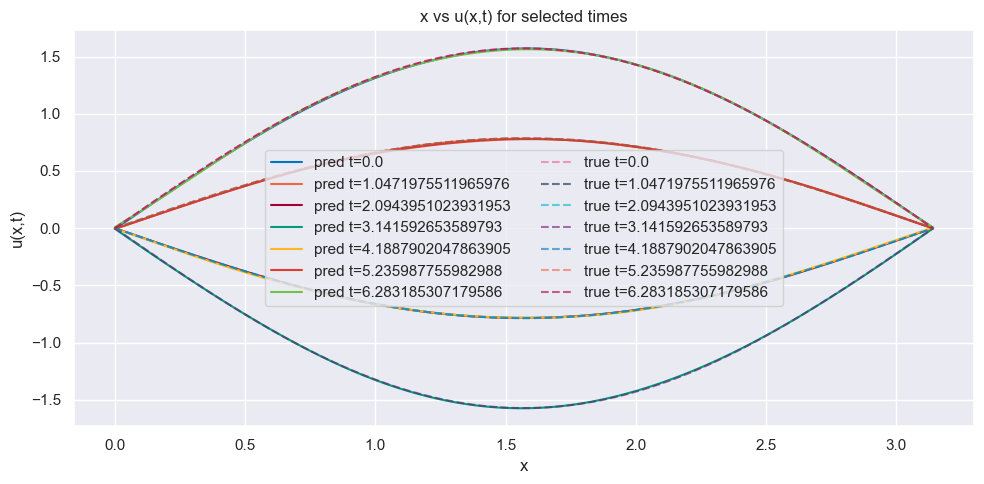

In [31]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=new_times, Nx =300, L_val=L, with_exact=True)

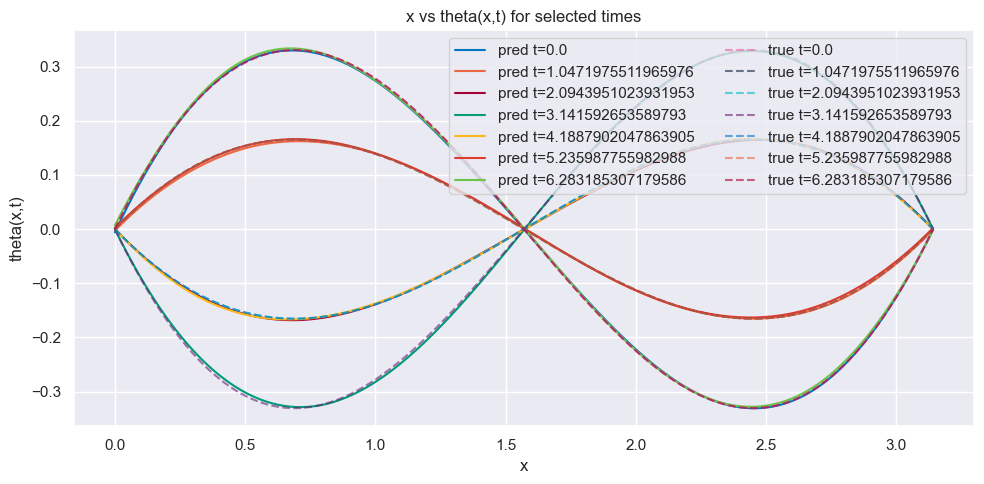

In [32]:
# Plot x vs theta(x,t) for multiple time instants using the trained model

def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the second for theta
            _, theta_pred_output = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            _, theta_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, theta_cpu in curves:
        plt.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if theta(x,t) is defined above
    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), theta_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('theta(x,t)')
    plt.title('x vs theta(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for theta
plot_x_vs_theta_at_times(pinn, times=new_times, Nx=300, L_val=L, with_exact=True)

In [35]:
# x_array = np.linspace(0, np.pi, 10000)
# t_array = np.linspace(0, 1, 10000)

# '''
# x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
# t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
# # Model now outputs two values (u, theta), so take the first for u
# u_pred_output, _ = pinn(torch.cat([x_tensor, t_tensor], dim=1)).split(1, dim=-1)
# u_pred = u_pred_output.cpu().detach().numpy()
# u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
# R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100
# '''

# x_tensor = torch.tensor(x_array, dtype=torch.float32).view(-1, 1).to(device)
# t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1).to(device)
# x_tensor_norm = x_normalizer.normalize(x_tensor)
# t_tensor_norm = t_normalizer.normalize(t_tensor)
# # Model now outputs two values (u, theta), so take the first for u
# u_pred_output_norm, _ = pinn(torch.cat([x_tensor_norm, t_tensor_norm], dim=1)).split(1, dim=-1)
# u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
# u_pred = u_pred_output_denorm.cpu().detach().numpy()
# u_exact_array = u_exact(x_tensor, t_tensor).cpu().detach().numpy()
# R = np.linalg.norm(u_pred - u_exact_array) / np.linalg.norm(u_exact_array) * 100

# print(R)

In [34]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    out_n = pinn(torch.cat([xg_n, tg_n], dim=1))
    u_n, theta_n = out_n.split(1, dim=-1)

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
theta_pred = theta_normalizer.denormalize(theta_n).cpu().numpy().reshape(Nx, Nt)

u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
theta_true = theta_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100
R_theta = np.linalg.norm(theta_pred - theta_true) / np.linalg.norm(theta_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (theta): {R_theta:.6f}%")

Grid relative error (u):     0.569494%
Grid relative error (theta): 1.673750%
